<center>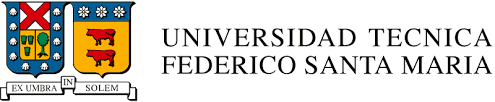</center>



<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477/577 Redes Neuronales Artificiales - 2022-2 </h1>

<H3 align='center'> Tarea 1  </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* Manipulaciones en pandas y numpy, imputación de datos y preprocesamientos
* Redes Densas Feed Forward
* Regularización y Dropout
* Vanishing Gradient
* Learn Rate Decay
* Optimizadores


**Formalidades**  
* Equipos de trabajo de 3 personas (*Los estudiantes deben estar preparados para presentar la tarea el día de la entrega*)
* El entregable debe ser un _Jupyter Notebook_ incluyendo los códigos utilizados, los resultados, los gráficos realizados y comentarios. Debe seguir una estructura similar a un informe (se debe introducir los problemas a trabajar, presentar los resultados y discutirlos), se penalizará fuertemente ausencia de comentarios, explicaciones de gráficos, _etc_. Si lo prefiere puede entregar un _Jupyter Notebook_ por pregunta o uno por toda la tarea, con tal de que todos los entregables esten bien identificados y se encuentren en el mismo repositorio de _Github_.
* Se debe preparar una presentación del trabajo realizado y sus hallazgos. El presentador será elegido aleatoriamente y deberá apoyarse en el _Jupyter Notebook_ que entregarán. 
* Formato de entrega: envı́o de link del repositorio en _Github_, al correo electrónico de los ayudantes (<maryon.morales@sansano.usm.cl>, <sebastian.sanchezl@sansano.usm.cl>), en copia al profesor (<cvalle@inf.utfsm.cl>). Especificar el siguiente asunto: [INF-395/477/577-2022-2 Tarea 1]. Invitar como colaborador a los usuarios de github "ssanchezl" y "maryonmorales" para poder acceder al repositorio en caso de ser privado.

* Fecha de presentaciones 07 de Octubre, en horario de clases.
* Fecha de entrega: 08 de Octubre. Hora límite de entrega: 12:00 p.m. Cualquier _commit_ luego de la hora límite no será evaluado. Se realizará descuento por atrasos en envío del mail igualmente.  

<hr style="height:2px;border:none"/>


* 1 - Redes Feed Forward para predicción de diabetes.

La tarea tiene ejemplos de códigos con los cuales pueden guiarse en gran parte, sin embargo, solo son guias y pueden ser creativos al momento de resolver la tarea. Soluciones creativas o elegantes serán valoradas. También en algunas ocaciones se hacen elecciones arbitrarias, ustedes pueden realizar otras elecciones con tal de que haya una pequeña justificación de por qué su elección es mejor o equivalente.
Recuerden intercalar su código con *comentarios* en celdas _Markdown_, con los comentarios de la pregunta y con cualquier análisis, fórmula (en $ \LaTeX $) o explicación que les parezca relevante para justificar sus procedimientos. *No respondan las preguntas en comentarios en el código*.
Noten que en general cuando se les pide elegir algo o proponer algo no se evaluará tanto la elección en si. En cambio la argumentación detrás de la elección será lo más ponderado.
Si algún modelo se demora demasiado en correr en su máquina, no olvide que puede correr _Jupyter Notebooks_ en _Collab_ de Google, incluso con la opción de aceleración con GPU (particularmente útil para los modelos más grandes), esto puede ser relevante para las máquinas más lentas al momento de realizar exploraciones con _K-folds_ o las redes más grandes. Existe también la posibilidad de utilizar _Google Cloud Plataform_ o _Amazon Web Service_, donde tienen máquinas aceleradas con GPU; maquinas ya configuradas para _deep leraning_ pueden encontrarse en el _Marketplace_ de cada proveedor de servicios.

# 1 - Redes Feed Forward para predicción de diabetes

De las redes neuronales artificiales más simples se encuentran las redes densas o Feed Forward, donde todas las neuronas de una capa estan conectadas a todos los inputs y envían su señal de activación a todas las neuronas de la siguiente capa. Estas redes, si bien son las más simples, suelen tener desempeños bastante buenos, y en muchas aplicaciones reales son utilizadas, ya sea por si solas o en combinación con otros modelos. Además, son las redes donde más facil se pueden observar muchos de los fenómenos que se han descubierto a lo largo de los años de desarrollo de esta area del conocimiento, tanto por ser de las redes vigentes más antiguas y por su estructura relativamente simple. En esta primera parte de la tarea exploraremos las redes densas y algunos de sus hiperparámetros más relevantes como la profundidad, el número de unidades; estudiaremos también algunos métodos de regularización y evidenciaremos el problema del vanishing gradient y el exploding gradient, viendo también algunos optimizadores existentes.

Para realizar esto, utilizaremos una base de datos de variables médicas predictoras de la diabetes en mujeres y la variable objetivo (presencia o ausencia de diabetes), la cual se encuentra disponible en Kaggle, en la siguiente URL: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database. Las variables predictoras incluyen el número de embarazos que ha tenido la paciente, su IMC, el nivel de insulina, la edad, entre otros. Nuesta tarea durante esta pregunta será predecir si la persona tiene o no de diabetes a partir de algunas de las otras variables presentes en el dataset. Para esto primero deberán explorar los atributos del dataset, imputar los valores que falten o eliminarlos en caso que estime conveniente, y luego preprocesar los datos de forma eficiente para que así puedan ser utilizados por una red neuronal. Una vez separados los datos de entrenamiento, validación y test, procederemos a entrenar diferentes modelos, comparandolos y evaluando sus desempeños.

## 1.0 Imports del codigo

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import TerminateOnNaN
from keras.layers import LeakyReLU
from keras.regularizers import l1, l2
from keras.layers import Dropout
from keras.callbacks import LearningRateScheduler
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
import sklearn.metrics
from sklearn.svm import SVC

C:\Users\Amanda\miniconda3\envs\redes\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 1.a Carga de datos y primeros análisis
Para cargar los datos, puede descargarlos desde el link de Kaggle, o puede descargarlos desde su jupyter nootebok como muestra el código a continuación. Para obtener más información acerca de como descargar datasets directamente desde la API de Kaggle puede dirigirse a la documentación que se encuentra en el siguiente link: https://github.com/Kaggle/kaggle-api#download-dataset-files. Para usar la API de Kaggle dentro de Google Colab puede serle de utilidad el siguiente link: https://galhever.medium.com/how-to-import-data-from-kaggle-to-google-colab-8160caa11e2.

Luego de descomprimir el archivo descargado cargue los datos en un *Dataframe* como muestra el código. Explore superficialmente los datos utilizando los metodos .head, .describe o .info del *Dataframe*.

In [2]:
df = pd.read_csv("diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


A continuación se describe el dataset, el cual contiene 9 columnas cada una con 768 datos. Todas las columnas tienen valores numéricos, sin valores nulos.

In [3]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Identifique y comente sobre las características de la variable objetivo (target) que sean relevantes para el problema. ¿Que puede decir acerca de la distribución de las clases?, ¿Están balanceadas? Explique usando gráficos que le parezcan pertinentes para representar el balance de clases. 



### Características de la variable objetivo

In [5]:
df["Outcome"].describe()

count    768.000000
mean       0.348958
std        0.476951
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Outcome, dtype: float64

In [6]:
pos_diab = df[df['Outcome'] != 0]["Outcome"]
neg_diab = df[df['Outcome'] == 0]["Outcome"]

pos_p= len(pos_diab)*100/768
neg_p=100-pos_p

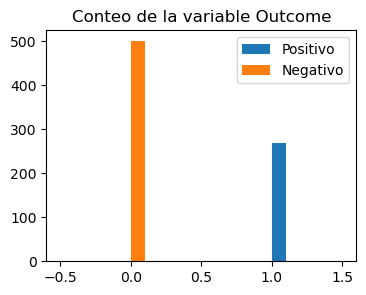

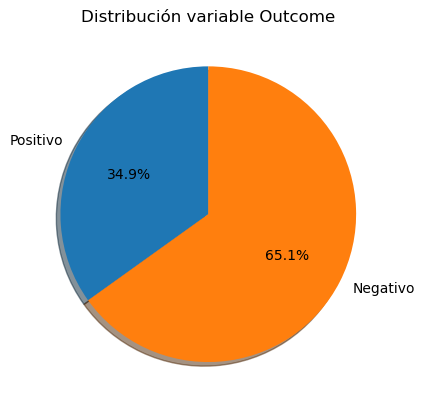

In [7]:


fig, ax = plt.subplots(1, 1, figsize=(4,3),)
plt.title("Conteo de la variable Outcome")
plt.hist(pos_diab, label='Positivo')
plt.hist(neg_diab, label='Negativo')
plt.legend()

labels = ['Positivo', 'Negativo']
sizes = [pos_p, neg_p]

fig1, ax1 = plt.subplots()
plt.title("Distribución variable Outcome")
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)

plt.show()

Se puede observar que la data está desbalanceada, con un 65,1% de resultados negativos respecto a la variable objetivo. Mientras que un 34,9% de resultados positivos

¿Qué puede observar de los datos, tiene sentido que algunos valores de ciertas variables predictoras tengan valor 0?, 

Identifique cuales son las columnas con datos faltantes que fueron imputadas con el valor 0. ¿Tiene sentido estos atributos tengan valores 0? Investigue el rango de valores que puede tomar cada atributo en el dataset, y comente sus principales características.

### Datos faltantes


1. Pregnancies: El rango de valores es normal, desde 0 embarazos hasta 17.
2. Glucose: Existen datos con valor 0, lo cual no tiene sentido ya que los valores normales varían entre 140 a 199 mg/dl
3. Blood Pressure: Existen datos con valor 0, lo cual no tiene sentido ya que los valores normales varían entre 90/60 hacia arriba
4. Skin Thickness: Existen valores 0, lo cual no tiene sentido ya que los valores más bajos son 6 - 2.60 mm
5. Insulina: Existen datos con valor 0, lo cual no tiene sentido ya que sus valores en personas no diabeticas fluctuan entre 60-100 mg/dl
6. BMI: Existen datos con valor 0, los valores normales fluctuan entre 18.5 to 24.9.
7. Función Pedigree Diabetes: No tiene valores 0
8. Edad: Los valores de edad varían entre 21 años hasta 81 años, por lo que están dentro del rango normal

En resumen las variables Glucose, Blood Preassure, Skin Thickness, Insulina, BMI, funcion Pedigree diabetes tiene datos imputados.

In [8]:
for column in df:
    print(column, ": ", len(df[df[column]==0]))

Pregnancies :  111
Glucose :  5
BloodPressure :  35
SkinThickness :  227
Insulin :  374
BMI :  11
DiabetesPedigreeFunction :  0
Age :  0
Outcome :  500


### Características


1. Pregnancies: En promedio las personas tiene aproximadamente 4 embarazos, menos del 25% tiene 1 embarazo o menos.
2. Glucose: En promedio se tiene una glucosa de 120.89 mg/dl (bajo de los rangos normales). Solo un 25% de la muestra está dentro de los rangos normales de glucosa
3. Blood Pressure: Menos de un 25% de personas está en el rango normal de presión arterial. En promedio se tiene un 69.105
4. Skin Thickness: En promedio se tiene un valor de 20.53, y menos del 50% esta en un rango normal.
5. Insulina: El valor promedio es de 79.79 y alrededor del 50% tiene bajo este valor.
6. BMI: El valor promedio es de 31.99, donde alrededor del 25% tiene valores bajo el rango normal.
7. Función Pedigree Diabetes: El valor promedio de la variable es 0.47.
8. Edad: El valor promedio es de 33 años y el 50% esta bajo los 30 años.

## 1.b Train Test Split

En esta pregunta nos ocuparemos de separar el dataset en los conjuntos de entrenamiento, validación y test y estandarizar los datos. Para esto puede utilizar la librería sklearn, en particular la función `train_test_split`. Para esto separe primero el dataset en  $X$  e  $Y$. Luego separe los datos considerando un  70%  de ellos para entrenamiento, un  20%  para validación y un  10%  para test. ¿Qué estamos tratando de representar en esta separación en conjuntos de entrenamiento, validación y test?

In [9]:
X = df.drop(columns=['Outcome'])
y = df["Outcome"]

X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.1, train_size=0.9)
X_tr, X_val, y_tr, y_val = train_test_split(X_tr, y_tr, test_size=1-(0.7*len(y)/len(y_tr)), train_size=(0.7*len(y)/len(y_tr)))

Objetivo de las divisiones de los datos:
1. Train: Se utiliza para entrenar el modelo (los pesos y bias)
2. Validación: Se utiliza para proveer una evaluación imparacial del modelo mientras se tunean los hiperparámetros
3. Test: Evalua el rendimiento del modelo final

## 1.c Valores faltantes e imputación

Tomando en cuenta solamente el conjunto de entrenamiento, considere los valores imputados con 0 que encontró en la pregunta 1.a y reemplacelos por `NaN`, para esto utilice el método `replace`. Cuente cuantos datos faltantes hay por cada atributo y grafíque. Cree 3 conjuntos de entrenamiento nuevos a partir del resultado de reemplazar con `NaN`:

1.   Conserve el conjunto de entrenamiento original intacto: $X_o$
2.   Reemplace los valores faltantes de cada columna por la media de estos: $X_1$
3.   Reemplace los valores faltantes de cada columna por la mediana de estos: $X_2$
4.   Reemplace los valores faltantes de cada columna utilizando el método MICE [1][2]: $X_3$

Responda las siguientes preguntas:

*   ¿Qué es la imputación de datos?
*   ¿Cuáles son las ventajas y desventajas de los 3 métodos recién utilizados versus sin imputar ($X_o$)?
*   ¿Qué se necesita para ejecutar cada uno de los 3 métodos de imputación de datos?
*   ¿Qué puede decir de los conjuntos resultantes?¿Resuelven el problema de los datos faltantes?





[1] https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.169.5745&rep=rep1&type=pdf

[2] https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html?highlight=mice




In [10]:
X0=X_tr.replace(0,0)
X_tr[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = X_tr[['Glucose',
'BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

X1 =X_tr.fillna(X_tr.mean())
X2 =X_tr.fillna(X_tr.median())

imputer = IterativeImputer(random_state=42)
imputer.fit(X_tr)
imputer=imputer.transform(X_tr)
X3 = pd.DataFrame(imputer, columns = X_tr.columns)

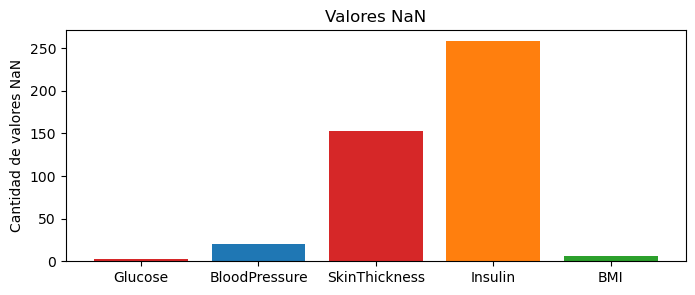

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8,3),)

Column = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
counts = X_tr.isna().sum()[Column]

bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange','tab:green']

ax.bar(Column, counts, color=bar_colors)

ax.set_ylabel('Cantidad de valores NaN')
ax.set_title('Valores NaN')

plt.show()

El gráfico muestra la cantidad de valores NaN para cada una de las columnas imputadas, se puede notar que hay una mayor cantidad de datos faltantes para la información de la Insulina y la columna SkinThickness.

A continuación se muestran la nueva descripción de la data para cada uno de los dataset creados.

In [12]:
X0.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000
mean,3.811918,120.085661,69.262570,20.636872,78.223464,32.247300,0.478186,32.746741
std,3.356327,31.941296,18.200581,15.472905,111.875407,7.933772,0.333718,11.257465
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,98.000000,62.000000,0.000000,0.000000,27.300000,0.252000,24.000000
50%,3.000000,116.000000,72.000000,23.000000,36.000000,32.000000,0.389000,29.000000
75%,6.000000,142.000000,78.000000,32.000000,127.000000,36.600000,0.614000,40.000000
max,17.000000,199.000000,122.000000,63.000000,846.000000,67.100000,2.420000,72.000000


In [13]:
X1.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000
mean,3.811918,120.760300,71.941973,28.859375,150.559140,32.611676,0.478186,32.746741
std,3.356327,30.644426,12.055396,8.331115,82.747827,7.153507,0.333718,11.257465
min,0.000000,44.000000,30.000000,7.000000,14.000000,18.200000,0.078000,21.000000
25%,1.000000,99.000000,64.000000,24.000000,120.000000,27.500000,0.252000,24.000000
50%,3.000000,116.000000,72.000000,28.859375,150.559140,32.300000,0.389000,29.000000
75%,6.000000,142.000000,78.000000,32.000000,150.559140,36.600000,0.614000,40.000000
max,17.000000,199.000000,122.000000,63.000000,846.000000,67.100000,2.420000,72.000000


In [14]:
X2.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000
mean,3.811918,120.733706,71.944134,28.899441,138.279330,32.604842,0.478186,32.746741
std,3.356327,30.646483,12.055401,8.331357,83.729175,7.153797,0.333718,11.257465
min,0.000000,44.000000,30.000000,7.000000,14.000000,18.200000,0.078000,21.000000
25%,1.000000,99.000000,64.000000,24.000000,120.000000,27.500000,0.252000,24.000000
50%,3.000000,116.000000,72.000000,29.000000,125.000000,32.000000,0.389000,29.000000
75%,6.000000,142.000000,78.000000,32.000000,127.000000,36.600000,0.614000,40.000000
max,17.000000,199.000000,122.000000,63.000000,846.000000,67.100000,2.420000,72.000000


In [15]:
X3.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000
mean,3.811918,120.661420,71.919946,28.517836,147.928395,32.594789,0.478186,32.746741
std,3.356327,30.680392,12.100468,9.020749,93.744347,7.157545,0.333718,11.257465
min,0.000000,44.000000,30.000000,7.000000,1.158475,18.200000,0.078000,21.000000
25%,1.000000,99.000000,64.000000,22.000000,86.545180,27.500000,0.252000,24.000000
50%,3.000000,116.000000,72.000000,28.000000,129.511306,32.000000,0.389000,29.000000
75%,6.000000,142.000000,78.099277,34.590368,184.000000,36.600000,0.614000,40.000000
max,17.000000,199.000000,122.000000,63.000000,846.000000,67.100000,2.420000,72.000000


### Respuestas
1. La imputacion de datos corresponde a la sustitucion de datos no observados por otros, en el sentido de que en la toma de datos estos no fueron observados por lo tanto ese campo se rellena con algún valor.
2. En base a los valores mostrados en la tabla de resumen, vemos lo siguiente: 
    Al aplicar el primer metodo de imputacion vemos como los promedios de las variables se mantienen respecto a los del dataset original pero la desviasion estandar de las varibles disminuye considerablemente (si se toma en cuenta la cantidad de valores Nan que habia en el dataset original). 
    Respecto al segundo metodo de imputación, vemos una disminucion en los valores del promedio y de la desviacion estantar.
    Finalmente, respecto al tercer metodo vemos que nuevamente el promedio y la desviacion estadar varian en comparacion al dataset original pero de una forma diferente a los metodos anteriores, la desviacion estandar disminuye pero no de una forma tan considerable que los metodos anteriores y el promedio en varias variables es inferior al que arroja los metodos anteriores pero suele ser un valor cercano al promedio del dataset original.
    Las mayores variaciones respecto al dataset original se producen en las variables que poseian una mayor cantidad de valores Nan.
3. Para el primer metodo se requiere el promedio de la variable, el segundo requiere la mediana de la variables, ambos metodos requieren que los valores de las variables sean numeros reales. El tercer metodo que usamos requiere ...
4. Todos los metodos resuelven el problema de la imputacion de datos para este dataset, ya que a todas las variables afectadas son variables numericas, por lo tanto es posible calcularles los elementos necesarios.

#### Tabla de resumen 
Forma de lectura: (X_0, X_1, X_2, X_3)

> 1. Glucosa mean = (122.31, 122.31, 122.26, 122.24)
> 2. Glucosa std = (30.77, 30.63, 30.63, 30.67)

> 1. BloodPreasure mean = (72.66, 72.66, 72.63, 72.60)
> 2. BloodPreasure std = (12.63, 12.38, 12.38, 12.43)

> 1. SkinThickness mean = (28.91, 28.91, 28.93, 28.84)
> 2. SkinThickness std = (10.70, 8.99, 8.99, 9.64)

> 1. Insulin mean = (157.49, 157.49, 142.12, 155.29)
> 2. Insulin std = (122.67, 87.71, 89.11, 100.53)

> 1. BMI mean = (32.50, 32.50, 32.50, 32.50)
> 2. BMI std = (6.95, 6.89, 6.89, 6.89)

## 1.d Estandarización

`Nota:` A menos que se indique explícitamente lo contrario, en esta y las siguientes preguntas realice los siguientes procedimientos y entrene las redes considerando como conjunto de entrenamiento cada $X \in \{X_o, X_1, X_2, X_3\}$ obtenido en la imputación anterior y comente las diferencias que observa en los desempeños de sus redes.

Ajuste los scalers con los datos de entrenamiento y transforme los datos para cada conjunto obtenido en la pregunta anterior.

- ¿Qué operación matemática realiza `StandarScaler` al momento de tranformar los datos? 
- ¿Por qué debemos transformar los datos de validación y de test con el _scaler_ ajustado a los datos de entrenamiento? 

In [16]:
##X0
scaler_xo = StandardScaler()
scaler_xo.fit(X0)
x_tr_o = scaler_xo.transform(X0)
x_val_o = scaler_xo.transform(X_val)

##X1
scaler_x1 = StandardScaler()
scaler_x1.fit(X1)
x_tr_1 = scaler_x1.transform(X1)
x_val_1 = scaler_x1.transform(X_val)

##X2
scaler_x2 = StandardScaler()
scaler_x2.fit(X2)
x_tr_2 = scaler_x2.transform(X2)
x_val_2 = scaler_x2.transform(X_val)

##X3
scaler_x3 = StandardScaler()
scaler_x3.fit(X3)
x_tr_3 = scaler_x3.transform(X3)
x_val_3 = scaler_x3.transform(X_val)


### Respuestas
1. StandarScaler realiza la extraccion del promedio de la variable a cada elemento y el resultado de la operacion es reescalado a la varianza unitaria.
2. La razon por la que es necesario transformar los datos es porque estos, originalmente presetan diferentes escalas lo cual deriva a un resultado sesgado (un error en la precision). 

[1] https://www.digitalocean.com/community/tutorials/standardscaler-function-in-python

## 1.e Primera Red
En esta pregunta construiremos y entrenaremos una primera red neuronal. Para esto utilizaremos la librería keras que se ocupa de crear, compilar y entrenar los modelos de manera simple. Keras se encargará por lo tanto de crear los modelos y al momento de compilarlos se instanciarán estos en una sesión de TensorFlow. 

Esta primera red será una red de una capa oculta con $256$ neuronas, activación ReLu. Para esta red y todas las demas utilizaremos la función de pérdida _Binary Cross Entropy_ ¿Porqué se ocupa esta función de pérdida?¿Qué función de activación se utiliza para la capa de salida en este tipo de problemas?¿Cuántas neuronas para la capa de salida?. Para entrenar esta primera red utilizaremos Gradiente Descendente Estocástico con un _Learn Rate_ de 0.002. Finalmente entrenaremos esta red por unas 20 _epochs_.

Construya la red basandose en el siguiente código y en la documentación de keras. 

In [17]:
ANN = Sequential()
ANN.add(Dense(units = 256, activation = 'relu'))
ANN.add(Dense(units = 1,activation='sigmoid'))
ANN.compile(optimizer=SGD(learning_rate=0.002),loss='binary_crossentropy')

In [18]:
def SDG(lr):
    model=Sequential()
    model.add(Dense(units = 256, activation = 'relu'))
    model.add(Dense(units = 1,activation='sigmoid'))
    model.compile(optimizer=SGD(learning_rate=lr),loss='binary_crossentropy')
    return model

### Respuesta

1. Porque este tipo de funciones nos permite comprobar el rendimiento de nuestra red para clasificar elementos de forma binaria.
2. Para este problema de clasificación binario, la funcion de activacion utilziada es la funcion sigmoidal.
3. Para la capa de salida solo tendremos una neurona, ya que estamos trabajando con una clasificación binaria.

### Dataset X0

In [19]:
m1_o= SDG(0.002)

Entrene la red por 20 _epochs_, guardando el `history` que retorna el metodo `.fit`.

In [20]:
history1_o = m1_o.fit(x_tr_o, y_tr, epochs=20, validation_data=(x_val_o,y_val))

Epoch 1/20
17/17 [==============================] - 1s 21ms/step - loss: 0.6778 - val_loss: 0.6540
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6729 - val_loss: 0.6493
Epoch 3/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6681 - val_loss: 0.6448
Epoch 4/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6635 - val_loss: 0.6404
Epoch 5/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6590 - val_loss: 0.6362
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6547 - val_loss: 0.6321
Epoch 7/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6504 - val_loss: 0.6282
Epoch 8/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6464 - val_loss: 0.6243
Epoch 9/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6424 - val_loss: 0.6205
Epoch 10/20
17/17 [==============================] - 0s 11ms/step - loss: 0.6385 - val_loss: 0.6169
Epoch 11/20
17/17

Utilice el método `.summary` para ver el número de parámetros de su red y los tamaños de cada capa. 

Explique el número de parámetros presentes en esta red, es decir: ¿Cómo a partir de la dimensión del _Input_ y el número de neuronas obtenemos ese número de parámetros?

In [21]:
m1_o.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 256)               2304      
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2,561
Trainable params: 2,561
Non-trainable params: 0
_________________________________________________________________


Para la primera capa se tiene 2304 parámetros y 256 neuronas que dan una salida. El input tiene 9 datos, que corresponde a la cantidad de columnas del dataset, luego, cada uno de esos se da como entrada a las 256 neuronas. Lo que lleva a un total de 2304 parámetros.

Grafique como varian los errores de validación y de entrenamiento a lo largo de las _epochs_. Comente.

### DataSet X0

##### Learning rate 0.002

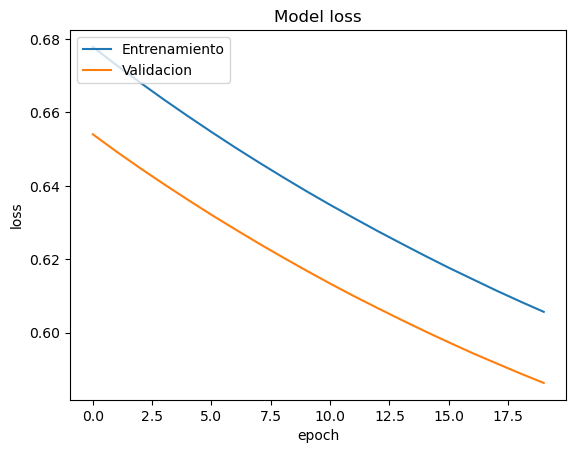

In [22]:
#Grafique como varian los errores de validación y de entrenamiento a lo largo de las epochs. Comente
plt.plot(history1_o.history['loss'])
plt.plot(history1_o.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Entrenamiento', 'Validacion'], loc='upper left')
plt.show()

Cree y entrene nuevamente la red, esta vez cambiando el _learn rate_ utilizado para el SGD. Pruebe a lo menos un valor mayor y un valor menor al elegido anteriormente. Note que para valores mayores al propuesto puede comenzar a observar fenómeno de divergencia, por lo cual es recomendable agregarle a la red un _callback_, es decir una función que verifica estados y comportamientos de la red mientras se entrena, en particular `TerminateOnNaN`, el cual interrumpirá el proceso de entrenamiento si encuentra un valor NaN. 

Grafique el comportamiento de los errores de validación y entrenamiento y comente.

##### Learning rate 0.009

In [23]:
m2_o= SDG(0.009)
history2_o = m2_o.fit(x_tr_o, y_tr, epochs=20, validation_data=(x_val_o,y_val))

Epoch 1/20
17/17 [==============================] - 1s 22ms/step - loss: 0.7110 - val_loss: 0.7110
Epoch 2/20
17/17 [==============================] - 0s 7ms/step - loss: 0.6786 - val_loss: 0.6775
Epoch 3/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6527 - val_loss: 0.6497
Epoch 4/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6310 - val_loss: 0.6273
Epoch 5/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6131 - val_loss: 0.6086
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5980 - val_loss: 0.5926
Epoch 7/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5847 - val_loss: 0.5789
Epoch 8/20
17/17 [==============================] - 0s 7ms/step - loss: 0.5734 - val_loss: 0.5672
Epoch 9/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5633 - val_loss: 0.5571
Epoch 10/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5545 - val_loss: 0.5482
Epoch 11/20
17/17 

#### Learning rate 0.009 - Terminate On NaN

In [24]:
m3_o= SDG(0.009)
history3_o = m3_o.fit(x_tr_o, y_tr, epochs=20, validation_data=(x_val_o,y_val),
                     callbacks=[TerminateOnNaN()]
                     )

Epoch 1/20
17/17 [==============================] - 1s 19ms/step - loss: 0.6988 - val_loss: 0.6908
Epoch 2/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6687 - val_loss: 0.6600
Epoch 3/20
17/17 [==============================] - 0s 8ms/step - loss: 0.6444 - val_loss: 0.6347
Epoch 4/20
17/17 [==============================] - 0s 7ms/step - loss: 0.6242 - val_loss: 0.6139
Epoch 5/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6072 - val_loss: 0.5964
Epoch 6/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5929 - val_loss: 0.5814
Epoch 7/20
17/17 [==============================] - 0s 7ms/step - loss: 0.5806 - val_loss: 0.5687
Epoch 8/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5697 - val_loss: 0.5575
Epoch 9/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5602 - val_loss: 0.5477
Epoch 10/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5517 - val_loss: 0.5391
Epoch 11/20
17/17 

##### Learning rate 0.0002

In [25]:
m4_o= SDG(0.0002)
history4_o = m4_o.fit(x_tr_o, y_tr, epochs=20, validation_data=(x_val_o,y_val))

Epoch 1/20
17/17 [==============================] - 1s 19ms/step - loss: 0.7312 - val_loss: 0.7375
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.7303 - val_loss: 0.7365
Epoch 3/20
17/17 [==============================] - 0s 5ms/step - loss: 0.7294 - val_loss: 0.7356
Epoch 4/20
17/17 [==============================] - 0s 5ms/step - loss: 0.7286 - val_loss: 0.7346
Epoch 5/20
17/17 [==============================] - 0s 5ms/step - loss: 0.7277 - val_loss: 0.7337
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 0.7268 - val_loss: 0.7327
Epoch 7/20
17/17 [==============================] - 0s 5ms/step - loss: 0.7260 - val_loss: 0.7318
Epoch 8/20
17/17 [==============================] - 0s 5ms/step - loss: 0.7251 - val_loss: 0.7308
Epoch 9/20
17/17 [==============================] - 0s 5ms/step - loss: 0.7243 - val_loss: 0.7299
Epoch 10/20
17/17 [==============================] - 0s 4ms/step - loss: 0.7234 - val_loss: 0.7290
Epoch 11/20
17/17 

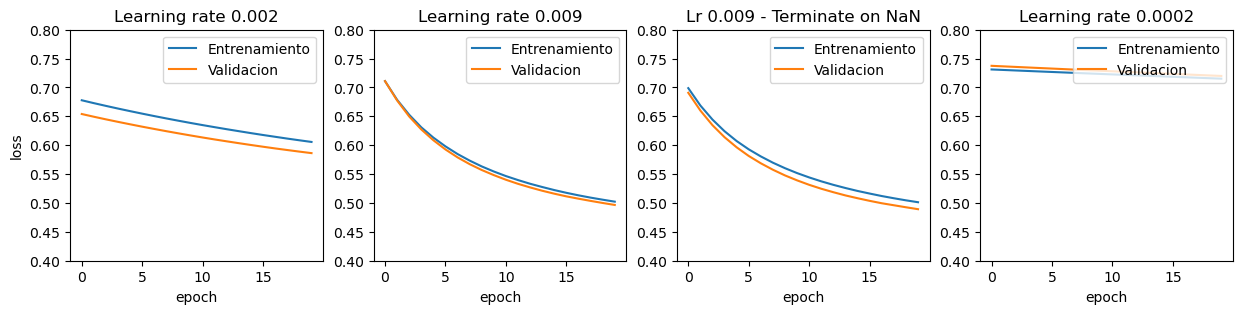

In [26]:
fig, ax = plt.subplots(1, 4, figsize=(15,3),)
aux = [history1_o, history2_o, history3_o,history4_o]

for i in range(len(aux)):
    ax[i].plot(aux[i].history['loss'])
    ax[i].plot(aux[i].history['val_loss'])
    ax[i].legend(['Entrenamiento', 'Validacion'], loc='upper right')
    ax[i].set_ylim(0.4, 0.8)
    ax[i].set_xlabel('epoch')
    
ax[0].set_title('Learning rate 0.002')
ax[1].set_title('Learning rate 0.009')
ax[2].set_title('Lr 0.009 - Terminate on NaN')
ax[3].set_title('Learning rate 0.0002')
ax[0].set_ylabel('loss')
plt.show()

De los gráficos se puede observar que el mejor resultado se obtiene para un Learning rate 0.002, por otro lado para valores muy grandes o muy pequeños los valores comienzan a diverger

### Dataset X1

##### Learning rate 0.002

In [27]:
m1_1= SDG(0.002)
history1_1 = m1_1.fit(x_tr_1, y_tr, epochs=20, validation_data=(x_val_1,y_val))

Epoch 1/20
17/17 [==============================] - 1s 19ms/step - loss: 0.6813 - val_loss: 0.6949
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6744 - val_loss: 0.6843
Epoch 3/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6678 - val_loss: 0.6744
Epoch 4/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6615 - val_loss: 0.6651
Epoch 5/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6555 - val_loss: 0.6563
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6497 - val_loss: 0.6481
Epoch 7/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6442 - val_loss: 0.6404
Epoch 8/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6389 - val_loss: 0.6331
Epoch 9/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6339 - val_loss: 0.6264
Epoch 10/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6290 - val_loss: 0.6199
Epoch 11/20
17/17 

##### Learning rate 0.009

In [28]:
m2_1= SDG(0.009)
history2_1 = m2_1.fit(x_tr_1, y_tr, epochs=20, validation_data=(x_val_1,y_val))
m2_1.summary()

Epoch 1/20
17/17 [==============================] - 1s 28ms/step - loss: 0.7826 - val_loss: 0.8964
Epoch 2/20
17/17 [==============================] - 0s 7ms/step - loss: 0.7324 - val_loss: 0.8145
Epoch 3/20
17/17 [==============================] - 0s 7ms/step - loss: 0.6929 - val_loss: 0.7506
Epoch 4/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6609 - val_loss: 0.7021
Epoch 5/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6352 - val_loss: 0.6638
Epoch 6/20
17/17 [==============================] - 0s 7ms/step - loss: 0.6140 - val_loss: 0.6338
Epoch 7/20
17/17 [==============================] - 0s 7ms/step - loss: 0.5963 - val_loss: 0.6103
Epoch 8/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5813 - val_loss: 0.5909
Epoch 9/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5684 - val_loss: 0.5755
Epoch 10/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5573 - val_loss: 0.5629
Epoch 11/20
17/17 

In [29]:
m4_1= SDG(0.009)
history4_1 = m4_1.fit(x_tr_1, y_tr, epochs=20, validation_data=(x_val_1,y_val),
                     callbacks=[TerminateOnNaN()]
                     )

Epoch 1/20
17/17 [==============================] - 1s 19ms/step - loss: 0.6553 - val_loss: 0.6173
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6310 - val_loss: 0.5940
Epoch 3/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6108 - val_loss: 0.5765
Epoch 4/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5937 - val_loss: 0.5629
Epoch 5/20
17/17 [==============================] - 0s 4ms/step - loss: 0.5787 - val_loss: 0.5526
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5661 - val_loss: 0.5443
Epoch 7/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5550 - val_loss: 0.5379
Epoch 8/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5452 - val_loss: 0.5329
Epoch 9/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5368 - val_loss: 0.5288
Epoch 10/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5293 - val_loss: 0.5256
Epoch 11/20
17/17 

##### Learning rate 0.0002

In [30]:
m3_1= SDG(0.0002)
history3_1 = m3_1.fit(x_tr_1, y_tr, epochs=20, validation_data=(x_val_1,y_val))
m3_1.summary()

Epoch 1/20
17/17 [==============================] - 1s 30ms/step - loss: 0.6625 - val_loss: 0.6568
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6619 - val_loss: 0.6560
Epoch 3/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6612 - val_loss: 0.6551
Epoch 4/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6606 - val_loss: 0.6543
Epoch 5/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6600 - val_loss: 0.6535
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6594 - val_loss: 0.6526
Epoch 7/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6588 - val_loss: 0.6518
Epoch 8/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6582 - val_loss: 0.6510
Epoch 9/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6577 - val_loss: 0.6502
Epoch 10/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6571 - val_loss: 0.6493
Epoch 11/20
17/17 

##### Graficos

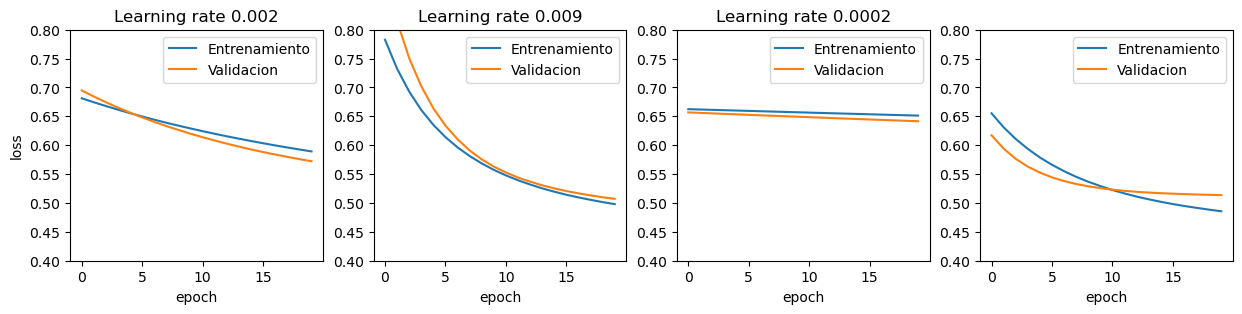

In [31]:
fig, ax = plt.subplots(1, 4, figsize=(15,3),)
aux = [history1_1, history2_1, history3_1, history4_1]

for i in range(len(aux)):
    ax[i].plot(aux[i].history['loss'])
    ax[i].plot(aux[i].history['val_loss'])
    ax[i].legend(['Entrenamiento', 'Validacion'], loc='upper right')
    ax[i].set_ylim(0.4, 0.8)
    ax[i].set_xlabel('epoch')
    
ax[0].set_title('Learning rate 0.002')
ax[1].set_title('Learning rate 0.009')
ax[2].set_title('Learning rate 0.0002')
ax[0].set_ylabel('loss')
plt.show()

De los gráficos se puede observar que el mejor resultado se obtiene para un Learning rate 0.002, por otro lado para valores muy grandes o muy pequeños los valores comienzan a diverger

### Dataset X2

##### Learning rate 0.002

In [32]:
m1_2= SDG(0.002)
history1_2 = m1_2.fit(x_tr_2, y_tr, epochs=20, validation_data=(x_val_2,y_val))
m1_2.summary()

Epoch 1/20
17/17 [==============================] - 1s 20ms/step - loss: 0.6797 - val_loss: 0.6512
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6738 - val_loss: 0.6450
Epoch 3/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6681 - val_loss: 0.6391
Epoch 4/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6626 - val_loss: 0.6334
Epoch 5/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6573 - val_loss: 0.6281
Epoch 6/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6522 - val_loss: 0.6230
Epoch 7/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6472 - val_loss: 0.6182
Epoch 8/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6424 - val_loss: 0.6136
Epoch 9/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6378 - val_loss: 0.6093
Epoch 10/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6333 - val_loss: 0.6051
Epoch 11/20
17/17 

##### Learning rate 0.009

In [33]:
m2_2= SDG(0.009)
history2_2 = m2_2.fit(x_tr_2, y_tr, epochs=20, validation_data=(x_val_2,y_val))

Epoch 1/20
17/17 [==============================] - 1s 20ms/step - loss: 0.6955 - val_loss: 0.6635
Epoch 2/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6636 - val_loss: 0.6319
Epoch 3/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6374 - val_loss: 0.6083
Epoch 4/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6158 - val_loss: 0.5904
Epoch 5/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5976 - val_loss: 0.5767
Epoch 6/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5823 - val_loss: 0.5661
Epoch 7/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5692 - val_loss: 0.5577
Epoch 8/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5578 - val_loss: 0.5511
Epoch 9/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5479 - val_loss: 0.5458
Epoch 10/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5392 - val_loss: 0.5414
Epoch 11/20
17/17 

In [34]:
m2_2= SDG(0.009)
history2_2 = m2_2.fit(x_tr_2, y_tr, epochs=20, validation_data=(x_val_2,y_val), callbacks=[TerminateOnNaN()] )

Epoch 1/20
17/17 [==============================] - 1s 20ms/step - loss: 0.6748 - val_loss: 0.6297
Epoch 2/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6492 - val_loss: 0.6046
Epoch 3/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6276 - val_loss: 0.5849
Epoch 4/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6091 - val_loss: 0.5695
Epoch 5/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5931 - val_loss: 0.5573
Epoch 6/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5792 - val_loss: 0.5477
Epoch 7/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5672 - val_loss: 0.5398
Epoch 8/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5565 - val_loss: 0.5336
Epoch 9/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5471 - val_loss: 0.5284
Epoch 10/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5388 - val_loss: 0.5241
Epoch 11/20
17/17 

##### Learning rate 0.0002

In [35]:
m3_2= SDG(0.0002)
history3_2 = m3_2.fit(x_tr_2, y_tr, epochs=20, validation_data=(x_val_2,y_val))

Epoch 1/20
17/17 [==============================] - 1s 20ms/step - loss: 0.7221 - val_loss: 0.7484
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.7212 - val_loss: 0.7469
Epoch 3/20
17/17 [==============================] - 0s 5ms/step - loss: 0.7202 - val_loss: 0.7455
Epoch 4/20
17/17 [==============================] - 0s 6ms/step - loss: 0.7193 - val_loss: 0.7441
Epoch 5/20
17/17 [==============================] - 0s 5ms/step - loss: 0.7184 - val_loss: 0.7427
Epoch 6/20
17/17 [==============================] - 0s 6ms/step - loss: 0.7175 - val_loss: 0.7413
Epoch 7/20
17/17 [==============================] - 0s 6ms/step - loss: 0.7166 - val_loss: 0.7400
Epoch 8/20
17/17 [==============================] - 0s 5ms/step - loss: 0.7157 - val_loss: 0.7386
Epoch 9/20
17/17 [==============================] - 0s 5ms/step - loss: 0.7148 - val_loss: 0.7373
Epoch 10/20
17/17 [==============================] - 0s 5ms/step - loss: 0.7139 - val_loss: 0.7359
Epoch 11/20
17/17 

##### Graficos

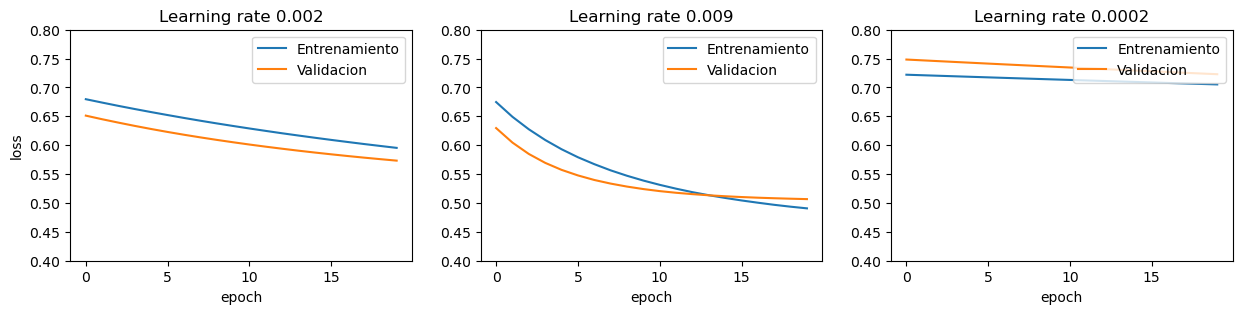

In [36]:
fig, ax = plt.subplots(1, 3, figsize=(15,3),)
aux = [history1_2, history2_2, history3_2]

for i in range(len(aux)):
    ax[i].plot(aux[i].history['loss'])
    ax[i].plot(aux[i].history['val_loss'])
    ax[i].legend(['Entrenamiento', 'Validacion'], loc='upper right')
    ax[i].set_ylim(0.4, 0.8)
    ax[i].set_xlabel('epoch')
    
ax[0].set_title('Learning rate 0.002')
ax[1].set_title('Learning rate 0.009')
ax[2].set_title('Learning rate 0.0002')
ax[0].set_ylabel('loss')
plt.show()

De los gráficos se puede observar que el mejor resultado se obtiene para un Learning rate 0.002, por otro lado para valores muy grandes o muy pequeños los valores comienzan a diverger

### Dataset X3

##### Learning rate 0.002

In [37]:
m1_3= SDG(0.002)
history1_3 = m1_3.fit(x_tr_3, y_tr, epochs=20, validation_data=(x_val_3,y_val))
m1_3.summary()

Epoch 1/20
17/17 [==============================] - 1s 20ms/step - loss: 0.7313 - val_loss: 0.7977
Epoch 2/20
17/17 [==============================] - 0s 6ms/step - loss: 0.7208 - val_loss: 0.7799
Epoch 3/20
17/17 [==============================] - 0s 6ms/step - loss: 0.7108 - val_loss: 0.7633
Epoch 4/20
17/17 [==============================] - 0s 6ms/step - loss: 0.7015 - val_loss: 0.7476
Epoch 5/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6925 - val_loss: 0.7327
Epoch 6/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6840 - val_loss: 0.7187
Epoch 7/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6760 - val_loss: 0.7056
Epoch 8/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6682 - val_loss: 0.6934
Epoch 9/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6609 - val_loss: 0.6818
Epoch 10/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6539 - val_loss: 0.6709
Epoch 11/20
17/17 

##### Learning rate 0.009

In [38]:
m2_3= SDG(0.002)
history2_3 = m2_3.fit(x_tr_3, y_tr, epochs=20, validation_data=(x_val_3,y_val))
m2_3.summary()

Epoch 1/20
17/17 [==============================] - 1s 20ms/step - loss: 0.7247 - val_loss: 0.6786
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.7147 - val_loss: 0.6695
Epoch 3/20
17/17 [==============================] - 0s 5ms/step - loss: 0.7053 - val_loss: 0.6609
Epoch 4/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6962 - val_loss: 0.6529
Epoch 5/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6875 - val_loss: 0.6455
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6793 - val_loss: 0.6386
Epoch 7/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6715 - val_loss: 0.6321
Epoch 8/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6641 - val_loss: 0.6261
Epoch 9/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6569 - val_loss: 0.6205
Epoch 10/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6502 - val_loss: 0.6153
Epoch 11/20
17/17 

##### Learning rate 0.0002

In [39]:
m3_3= SDG(0.002)
history3_3 = m3_3.fit(x_tr_3, y_tr, epochs=20, validation_data=(x_val_3,y_val))
m3_3.summary()

Epoch 1/20
17/17 [==============================] - 1s 21ms/step - loss: 0.6720 - val_loss: 0.6484
Epoch 2/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6650 - val_loss: 0.6408
Epoch 3/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6584 - val_loss: 0.6336
Epoch 4/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6521 - val_loss: 0.6268
Epoch 5/20
17/17 [==============================] - 0s 7ms/step - loss: 0.6459 - val_loss: 0.6204
Epoch 6/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6401 - val_loss: 0.6143
Epoch 7/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6345 - val_loss: 0.6085
Epoch 8/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6290 - val_loss: 0.6031
Epoch 9/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6239 - val_loss: 0.5980
Epoch 10/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6189 - val_loss: 0.5931
Epoch 11/20
17/17 

##### Graficos

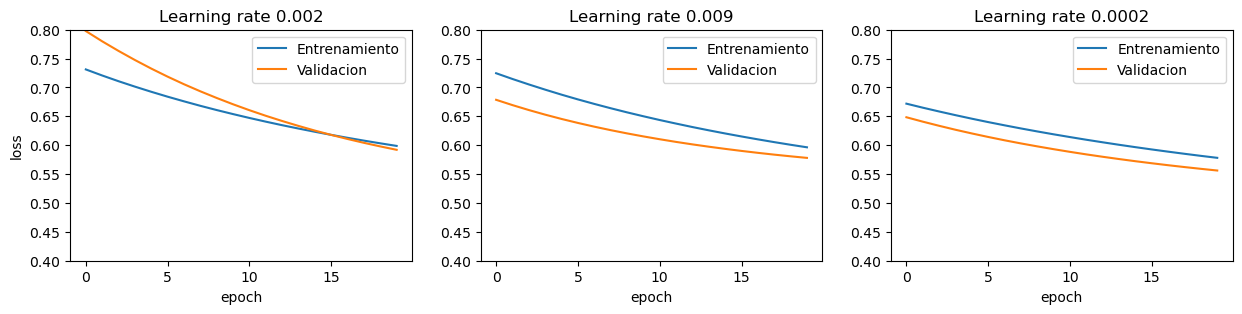

In [40]:
fig, ax = plt.subplots(1, 3, figsize=(15,3),)
aux = [history1_3, history2_3, history3_3]

for i in range(len(aux)):
    ax[i].plot(aux[i].history['loss'])
    ax[i].plot(aux[i].history['val_loss'])
    ax[i].legend(['Entrenamiento', 'Validacion'], loc='upper right')
    ax[i].set_ylim(0.4, 0.8)
    ax[i].set_xlabel('epoch')
    
ax[0].set_title('Learning rate 0.002')
ax[1].set_title('Learning rate 0.009')
ax[2].set_title('Learning rate 0.0002')
ax[0].set_ylabel('loss')
plt.show()

### Graficos comparativos

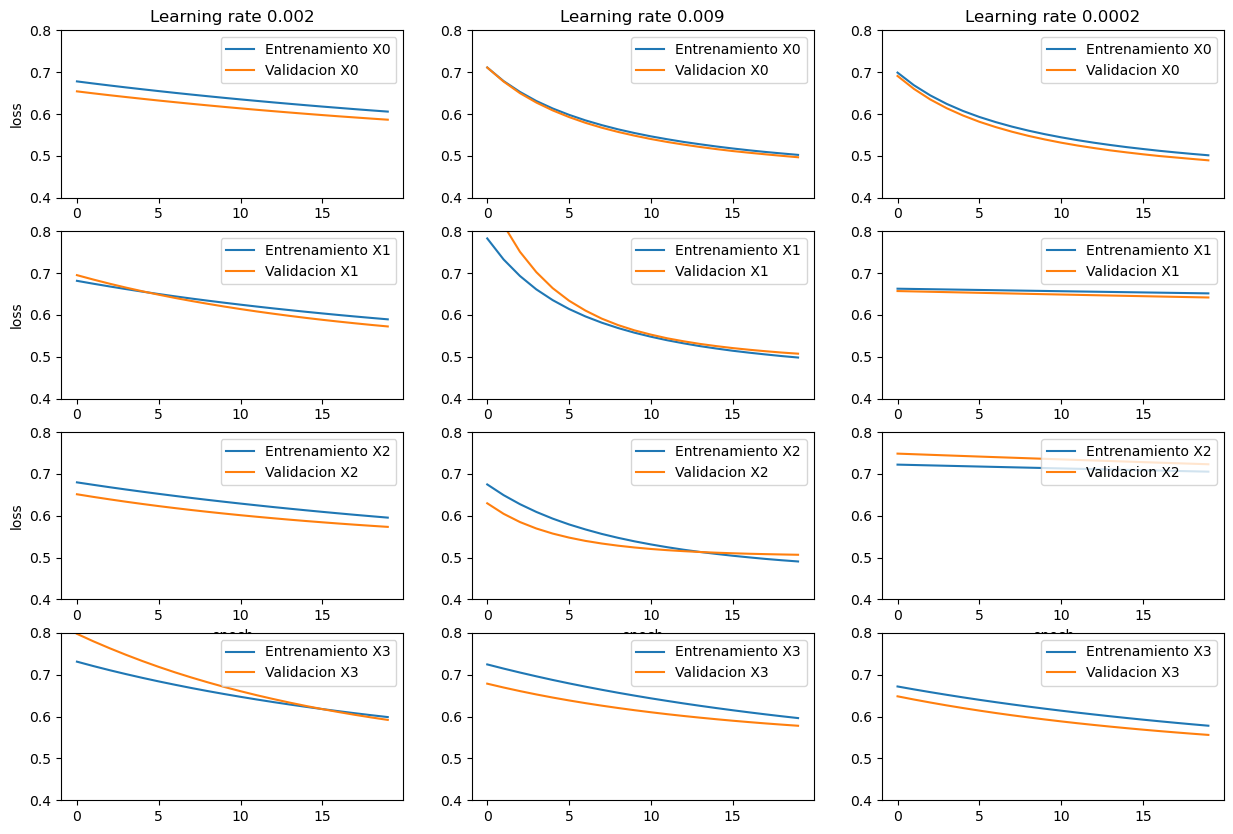

In [41]:
fig, ax = plt.subplots(4, 3, figsize=(15,10),)
aux = [[history1_o, history2_o, history3_o], [history1_1, history2_1, history3_1], [history1_2, history2_2, history3_2], [history1_3, history2_3, history3_3] ]
aux2 = ["X0","X1", "X2", "X3"]

for i in range(len(aux)):
    for j in range(len(aux)-1):
        ax[i,j].plot(aux[i][j].history['loss'])
        ax[i,j].plot(aux[i][j].history['val_loss'])
        ax[i,j].legend(['Entrenamiento ' + aux2[i], 'Validacion ' + aux2[i]], loc='upper right')
        ax[i,j].set_ylim(0.4, 0.8)
    
ax[0,0].set_title('Learning rate 0.002')
ax[0,1].set_title('Learning rate 0.009')
ax[0,2].set_title('Learning rate 0.0002')
ax[2,0].set_xlabel('epoch')
ax[2,1].set_xlabel('epoch')
ax[2,2].set_xlabel('epoch')
ax[0,0].set_ylabel('loss')
ax[1,0].set_ylabel('loss')
ax[2,0].set_ylabel('loss')
plt.show()

De los gráficos se puede observar que el mejor resultado se obtiene para un Learning rate 0.002, por otro lado para valores muy grandes o muy pequeños los valores comienzan a diverger

## 1.f Activación y regularizadores $l1$ $l2$
En esta pregunta se les propone explorar distintas funciones de activación y de regularización. En ambos casos debe entrenar la misma red entrenada anteriormente utilizando gradiente descendente estocástico con algun _learn rate_ que le parezca adecuado luego de la exploración en la pregunta anterior. 

* Para explorar distintas funciones de activación, cambie la activación de la capa oculta sucesivamente por: tangente hiperbólica, _Leaky ReLu_, sigmoidea y lineal. Para esto puede basarse en el código presentado abajo y la documentación de keras. Para la activación _Leaky ReLu_ pruebe cambiar el parámetro de la red. Describa sus resultados y si observa diferencias entre las redes. 

¿Para qué se usan activaciones no lineales? ¿Le parece buena opción la activación sigmoidea para la capa oculta?

¿Cual es la intención de la regularización en general? En particular, ¿Que restricción implicita imponen las regularizaciones $l$1 o $l$2 sobre los pesos de la capa en la cual se aplican? Apoyese de ecuaciones.

In [42]:
def Active(lr,activation):
    model=Sequential()
    model.add(Dense(units = 256, activation = activation))
    model.add(Dense(units = 1,activation='sigmoid'))
    model.compile(optimizer=SGD(learning_rate=lr),loss='binary_crossentropy')
    return model

### Respuestas

1. Los activadores no lineales se usan en problemas de clasificacion. Como estamos trabajando con un problema de clasficicacion binaria, el uso de la funcion sigmoidal parece una opcion aceptable dentro de las funciones no lineales.

2. La regularización se usa para controlar los valores de los pesos que se calculan en la red, esto para impedir el overfitting.

### Dataset X0

In [43]:
learning_r=0.009

In [44]:
model1 = Active(learning_r,'linear')
history1 = model1.fit(x_tr_o, y_tr, epochs=20, validation_data=(x_val_o,y_val))

Epoch 1/20
17/17 [==============================] - 1s 23ms/step - loss: 0.6763 - val_loss: 0.6626
Epoch 2/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6210 - val_loss: 0.6265
Epoch 3/20
17/17 [==============================] - 0s 7ms/step - loss: 0.5858 - val_loss: 0.6011
Epoch 4/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5611 - val_loss: 0.5821
Epoch 5/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5435 - val_loss: 0.5673
Epoch 6/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5301 - val_loss: 0.5548
Epoch 7/20
17/17 [==============================] - 0s 7ms/step - loss: 0.5198 - val_loss: 0.5441
Epoch 8/20
17/17 [==============================] - 0s 7ms/step - loss: 0.5112 - val_loss: 0.5348
Epoch 9/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5046 - val_loss: 0.5265
Epoch 10/20
17/17 [==============================] - 0s 7ms/step - loss: 0.4990 - val_loss: 0.5192
Epoch 11/20
17/17 

In [45]:
model2 = Active(learning_r,'tanh')
history2 = model2.fit(x_tr_o, y_tr, epochs=20, validation_data=(x_val_o,y_val))

Epoch 1/20
17/17 [==============================] - 1s 22ms/step - loss: 0.6663 - val_loss: 0.6538
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6141 - val_loss: 0.6154
Epoch 3/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5798 - val_loss: 0.5888
Epoch 4/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5558 - val_loss: 0.5693
Epoch 5/20
17/17 [==============================] - 0s 7ms/step - loss: 0.5386 - val_loss: 0.5541
Epoch 6/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5256 - val_loss: 0.5417
Epoch 7/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5154 - val_loss: 0.5317
Epoch 8/20
17/17 [==============================] - 0s 8ms/step - loss: 0.5075 - val_loss: 0.5230
Epoch 9/20
17/17 [==============================] - 0s 8ms/step - loss: 0.5012 - val_loss: 0.5157
Epoch 10/20
17/17 [==============================] - 0s 7ms/step - loss: 0.4960 - val_loss: 0.5091
Epoch 11/20
17/17 

In [46]:
model3 = Active(learning_r,'sigmoid')
history3 = model3.fit(x_tr_o, y_tr, epochs=20, validation_data=(x_val_o,y_val))

Epoch 1/20
17/17 [==============================] - 1s 25ms/step - loss: 0.6612 - val_loss: 0.6094
Epoch 2/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6427 - val_loss: 0.5928
Epoch 3/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6383 - val_loss: 0.5858
Epoch 4/20
17/17 [==============================] - 0s 7ms/step - loss: 0.6330 - val_loss: 0.6019
Epoch 5/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6324 - val_loss: 0.5860
Epoch 6/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6256 - val_loss: 0.5749
Epoch 7/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6237 - val_loss: 0.5837
Epoch 8/20
17/17 [==============================] - 0s 7ms/step - loss: 0.6198 - val_loss: 0.5719
Epoch 9/20
17/17 [==============================] - 0s 7ms/step - loss: 0.6164 - val_loss: 0.5669
Epoch 10/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6134 - val_loss: 0.5667
Epoch 11/20
17/17 

In [47]:
model4 = Sequential()

# Hidden Layer
model4.add(
    Dense(
        units = 256, 
        activation = LeakyReLU()
    )
)

# Output Layer
model4.add(
    Dense(
       units = 1,
       activation='sigmoid'
    )
)


model4.compile(
    optimizer=SGD(learning_rate=learning_r),
    loss='binary_crossentropy'
)
history4 = model4.fit(x_tr_o, y_tr, epochs=20, validation_data=(x_val_o,y_val))

Epoch 1/20
17/17 [==============================] - 1s 21ms/step - loss: 0.6541 - val_loss: 0.6441
Epoch 2/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6255 - val_loss: 0.6186
Epoch 3/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6020 - val_loss: 0.5971
Epoch 4/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5828 - val_loss: 0.5795
Epoch 5/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5669 - val_loss: 0.5647
Epoch 6/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5536 - val_loss: 0.5520
Epoch 7/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5423 - val_loss: 0.5411
Epoch 8/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5326 - val_loss: 0.5316
Epoch 9/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5244 - val_loss: 0.5233
Epoch 10/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5173 - val_loss: 0.5160
Epoch 11/20
17/17 

Podemos notar que para el DataSet X0 no fue posible ajustar el modelo debido a los valores nan en cada columna.

### Dataset X1

In [48]:
model1 = Active(learning_r,'linear')
history1 = model1.fit(x_tr_1, y_tr, epochs=20, validation_data=(x_val_1,y_val))

Epoch 1/20
17/17 [==============================] - 1s 21ms/step - loss: 0.6941 - val_loss: 0.6462
Epoch 2/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6190 - val_loss: 0.5893
Epoch 3/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5762 - val_loss: 0.5600
Epoch 4/20
17/17 [==============================] - 0s 12ms/step - loss: 0.5502 - val_loss: 0.5419
Epoch 5/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5327 - val_loss: 0.5298
Epoch 6/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5197 - val_loss: 0.5210
Epoch 7/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5105 - val_loss: 0.5143
Epoch 8/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5031 - val_loss: 0.5087
Epoch 9/20
17/17 [==============================] - 0s 6ms/step - loss: 0.4974 - val_loss: 0.5040
Epoch 10/20
17/17 [==============================] - 0s 7ms/step - loss: 0.4928 - val_loss: 0.4997
Epoch 11/20
17/17

In [49]:
model2 = Active(learning_r,'tanh')
history2 = model2.fit(x_tr_1, y_tr, epochs=20, validation_data=(x_val_1,y_val))

Epoch 1/20
17/17 [==============================] - 1s 23ms/step - loss: 0.6342 - val_loss: 0.6361
Epoch 2/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5857 - val_loss: 0.5843
Epoch 3/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5548 - val_loss: 0.5524
Epoch 4/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5344 - val_loss: 0.5322
Epoch 5/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5202 - val_loss: 0.5180
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5098 - val_loss: 0.5077
Epoch 7/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5019 - val_loss: 0.4998
Epoch 8/20
17/17 [==============================] - 0s 6ms/step - loss: 0.4955 - val_loss: 0.4934
Epoch 9/20
17/17 [==============================] - 0s 8ms/step - loss: 0.4909 - val_loss: 0.4882
Epoch 10/20
17/17 [==============================] - 0s 6ms/step - loss: 0.4869 - val_loss: 0.4836
Epoch 11/20
17/17 

In [50]:
model3 = Active(learning_r,'sigmoid')
history3 = model3.fit(x_tr_1, y_tr, epochs=20, validation_data=(x_val_1,y_val))

Epoch 1/20
17/17 [==============================] - 1s 21ms/step - loss: 0.6607 - val_loss: 0.6084
Epoch 2/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6508 - val_loss: 0.5958
Epoch 3/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6445 - val_loss: 0.5938
Epoch 4/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6395 - val_loss: 0.5856
Epoch 5/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6349 - val_loss: 0.5834
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6317 - val_loss: 0.5745
Epoch 7/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6271 - val_loss: 0.5801
Epoch 8/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6215 - val_loss: 0.5686
Epoch 9/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6189 - val_loss: 0.5669
Epoch 10/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6137 - val_loss: 0.5737
Epoch 11/20
17/17 

In [51]:
def Relu(a):
    model = Sequential()
    model.add(Dense(units = 256))
    model.add(LeakyReLU(alpha=a))
    model.add(Dense(units = 1,activation='sigmoid'))
    model.compile(optimizer=SGD(learning_rate=learning_r),loss='binary_crossentropy')
    return model

In [52]:
RegVal = [0.01,0.0002,0.2,0.3,0.5]
minLoss1 = []
minTrain1 = []

for i in RegVal:
    model4 = Relu(i)
    history4 = model4.fit(x_tr_1, y_tr, epochs=20, validation_data=(x_val_1,y_val))
    minLoss1.append(history4.history['val_loss'][19])
    minTrain1.append(history4.history['loss'][19])

Epoch 1/20
17/17 [==============================] - 1s 20ms/step - loss: 0.7317 - val_loss: 0.7239
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.7018 - val_loss: 0.6867
Epoch 3/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6763 - val_loss: 0.6567
Epoch 4/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6537 - val_loss: 0.6316
Epoch 5/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6341 - val_loss: 0.6114
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6169 - val_loss: 0.5943
Epoch 7/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6017 - val_loss: 0.5802
Epoch 8/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5881 - val_loss: 0.5684
Epoch 9/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5760 - val_loss: 0.5585
Epoch 10/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5653 - val_loss: 0.5504
Epoch 11/20
17/17 

In [53]:
aux = [history1, history2, history3,history4]
val_loss=[]
val_loss.append(history1.history['val_loss'][19])
val_loss.append(history2.history['val_loss'][19])
val_loss.append(history3.history['val_loss'][19])
val_loss.append(min(minTrain1))
val_loss

[0.47241923213005066,
 0.4605332911014557,
 0.5354759693145752,
 0.47402846813201904]

In [54]:
aux = [history1, history2, history3,history4]
loss=[]
loss.append(history1.history['loss'][19])
loss.append(history2.history['loss'][19])
loss.append(history3.history['loss'][19])
loss.append(min(minLoss1))
loss

[0.47181180119514465,
 0.46977922320365906,
 0.5803377032279968,
 0.4911370575428009]

Para el dataset X1, se puede concluir que el mejor valor obtenido es con la función de activación tangente hiperbólica

### Dataset X2

In [55]:

print("Linear")
model1 = Active(learning_r,'linear')
history1 = model1.fit(x_tr_2, y_tr, epochs=20, validation_data=(x_val_2,y_val))
print("Tanh")
model2 = Active(learning_r,'tanh')
history2 = model2.fit(x_tr_2, y_tr, epochs=20, validation_data=(x_val_2,y_val))
print("Sigmoid")
model3 = Active(learning_r,'sigmoid')
history3 = model3.fit(x_tr_2, y_tr, epochs=20, validation_data=(x_val_2,y_val))

print("LeakyRelu")
RegVal = [0.01,0.0002,0.2,0.3,0.5]
minLoss1 = []
minTrain1 = []
for i in RegVal:
    model4 = Relu(i)
    history4 = model4.fit(x_tr_2, y_tr, epochs=20, validation_data=(x_val_2,y_val))
    minLoss1.append(history4.history['val_loss'][19])
    minTrain1.append(history4.history['loss'][19])

Linear
Epoch 1/20
17/17 [==============================] - 1s 20ms/step - loss: 0.6495 - val_loss: 0.6013
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5930 - val_loss: 0.5639
Epoch 3/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5595 - val_loss: 0.5441
Epoch 4/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5385 - val_loss: 0.5319
Epoch 5/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5240 - val_loss: 0.5234
Epoch 6/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5136 - val_loss: 0.5170
Epoch 7/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5056 - val_loss: 0.5118
Epoch 8/20
17/17 [==============================] - 0s 6ms/step - loss: 0.4994 - val_loss: 0.5069
Epoch 9/20
17/17 [==============================] - 0s 5ms/step - loss: 0.4945 - val_loss: 0.5028
Epoch 10/20
17/17 [==============================] - 0s 6ms/step - loss: 0.4903 - val_loss: 0.4988
Epoch 11/20

In [56]:
aux = [history1, history2, history3,history4]
val_loss=[]
val_loss.append(history1.history['val_loss'][19])
val_loss.append(history2.history['val_loss'][19])
val_loss.append(history3.history['val_loss'][19])
val_loss.append(min(minLoss1))
val_loss

[0.47277721762657166,
 0.47342053055763245,
 0.546075701713562,
 0.4711622893810272]

In [57]:
aux = [history1, history2, history3,history4]
loss=[]
loss.append(history1.history['loss'][19])
loss.append(history2.history['loss'][19])
loss.append(history3.history['loss'][19])
loss.append(min(minLoss1))
loss

[0.47143256664276123,
 0.4746256172657013,
 0.5809558033943176,
 0.4711622893810272]

#### Capa oculta
La funcion de activacion que presenta mejor rendimiento es la lineal

Lineal -> Loss:0.53 ValLoss:0.54

Tanh -> Loss:0.53 ValLoss:0.52

Sigmoid -> Loss:0.63 ValLoss:0.63

Seq -> Loss:0.55 ValLoss:0.59

### Dataset X3

In [58]:
print("Linear")
model1 = Active(learning_r,'linear')
history1 = model1.fit(x_tr_3, y_tr, epochs=20, validation_data=(x_val_3,y_val))
print("Tanh")
model2 = Active(learning_r,'tanh')
history2 = model2.fit(x_tr_3, y_tr, epochs=20, validation_data=(x_val_3,y_val))
print("Sigmoid")
model3 = Active(learning_r,'sigmoid')
history3 = model3.fit(x_tr_3, y_tr, epochs=20, validation_data=(x_val_3,y_val))

print("LeakyRelu")
RegVal = [0.01,0.0002,0.2,0.3,0.5]
minLoss1 = []
minTrain1 = []
for i in RegVal:
    model4 = Relu(i)
    history4 = model4.fit(x_tr_3, y_tr, epochs=20, validation_data=(x_val_3,y_val))
    minLoss1.append(history4.history['val_loss'][19])
    minTrain1.append(history4.history['loss'][19])


Linear
Epoch 1/20
17/17 [==============================] - 1s 21ms/step - loss: 0.7004 - val_loss: 0.6292
Epoch 2/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6147 - val_loss: 0.5845
Epoch 3/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5686 - val_loss: 0.5623
Epoch 4/20
17/17 [==============================] - 0s 8ms/step - loss: 0.5414 - val_loss: 0.5495
Epoch 5/20
17/17 [==============================] - 0s 7ms/step - loss: 0.5244 - val_loss: 0.5409
Epoch 6/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5128 - val_loss: 0.5339
Epoch 7/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5040 - val_loss: 0.5286
Epoch 8/20
17/17 [==============================] - 0s 6ms/step - loss: 0.4975 - val_loss: 0.5235
Epoch 9/20
17/17 [==============================] - 0s 6ms/step - loss: 0.4927 - val_loss: 0.5188
Epoch 10/20
17/17 [==============================] - 0s 6ms/step - loss: 0.4884 - val_loss: 0.5145
Epoch 11/20

In [59]:
aux = [history1, history2, history3,history4]
val_loss=[]
val_loss.append(history1.history['val_loss'][19])
val_loss.append(history2.history['val_loss'][19])
val_loss.append(history3.history['val_loss'][19])
val_loss.append(min(minLoss1))
val_loss

[0.48774510622024536,
 0.4854850172996521,
 0.526312530040741,
 0.49704474210739136]

In [60]:
aux = [history1, history2, history3,history4]
loss=[]
loss.append(history1.history['loss'][19])
loss.append(history2.history['loss'][19])
loss.append(history3.history['loss'][19])
loss.append(min(minLoss1))
loss

[0.470851868391037,
 0.47365522384643555,
 0.5537815093994141,
 0.49704474210739136]

Por lo tanto, para el dataset X3 la funcion de activacion que presenta mejor rendimiento es la tangente hiperbólica


### Regularizadores
* Seleccione la función de activación que mejor resultados le dió y agregue regularización $l1$ a la capa oculta, luego pruebe con $l2$. Pruebe cambiar la tasa de regularización, reportando sus resultados. ¿Qué ocurre si la regularización es muy alta o muy baja? Una vez satisfecho con una tasa de regularización, aplique la regularización a la capa de salida y luego a ambas capas. 

In [61]:
#Regularizado l1 en capa oculta
def Regularizador1(lr,activation,reg):
    model=Sequential()
    model.add(Dense(units = 256, activation = activation,activity_regularizer=l1(reg)))
    model.add(Dense(units = 1,activation='sigmoid'))
    model.compile(optimizer=SGD(learning_rate=lr),loss='binary_crossentropy')
    return model

#Regularizado l2 en capa oculta
def Regularizador2(lr,activation,reg):
    model=Sequential()
    model.add(Dense(units = 256, activation = activation,activity_regularizer=l2(reg)))
    model.add(Dense(units = 1,activation='sigmoid'))
    model.compile(optimizer=SGD(learning_rate=lr),loss='binary_crossentropy')
    return model

In [62]:
#Regularizado l1 en capa salida
def Salida1(lr,activation,reg):
    model=Sequential()
    model.add(Dense(units = 256, activation = activation))
    model.add(Dense(units = 1,activation='sigmoid',activity_regularizer=l1(reg)))
    model.compile(optimizer=SGD(learning_rate=lr),loss='binary_crossentropy')
    return model

#Regularizado l2 en capa salida
def Salida2(lr,activation,reg):
    model=Sequential()
    model.add(Dense(units = 256, activation = activation))
    model.add(Dense(units = 1,activation='sigmoid',activity_regularizer=l2(reg)))
    model.compile(optimizer=SGD(learning_rate=lr),loss='binary_crossentropy')
    return model

In [63]:
#Regularizado l1 en ambas capas
def Ambas1(lr,activation,reg):
    model=Sequential()
    model.add(Dense(units = 256, activation = activation,activity_regularizer=l1(reg)))
    model.add(Dense(units = 1,activation='sigmoid',activity_regularizer=l1(reg)))
    model.compile(optimizer=SGD(learning_rate=lr),loss='binary_crossentropy')
    return model

#Regularizado l2 en capa salida
def Ambas2(lr,activation,reg):
    model=Sequential()
    model.add(Dense(units = 256, activation = activation,activity_regularizer=l2(reg)))
    model.add(Dense(units = 1,activation='sigmoid',activity_regularizer=l2(reg)))
    model.compile(optimizer=SGD(learning_rate=lr),loss='binary_crossentropy')
    return model

### Regularizadores

#### Dataset X0

In [65]:
RegVal = [0.00001, 0.0001, 0.001, 0.01, 0.1]
RegVal = np.linspace(0.00001, 1, 11)
minLoss0_1 = []
minTrain0_1 = []
minLoss0_2 = []
minTrain0_2 = []

for i in RegVal:
    model_reg2 = Regularizador1(learning_r,'tanh',i)
    history2 = model_reg2.fit(x_tr_o, y_tr, epochs=20, validation_data=(x_val_o,y_val))
    minLoss0_1.append(history2.history['val_loss'][19])
    minTrain0_1.append(history2.history['loss'][19])
    
    model_reg2 = Regularizador2(learning_r,'tanh',i)
    history2 = model_reg2.fit(x_tr_o, y_tr, epochs=20, validation_data=(x_val_o,y_val))
    minLoss0_2.append(history2.history['val_loss'][19])
    minTrain0_2.append(history2.history['loss'][19])

Epoch 1/20
17/17 [==============================] - 1s 27ms/step - loss: 0.6982 - val_loss: 0.6591
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6308 - val_loss: 0.6116
Epoch 3/20
17/17 [==============================] - 0s 7ms/step - loss: 0.5890 - val_loss: 0.5812
Epoch 4/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5613 - val_loss: 0.5604
Epoch 5/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5423 - val_loss: 0.5451
Epoch 6/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5285 - val_loss: 0.5331
Epoch 7/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5178 - val_loss: 0.5234
Epoch 8/20
17/17 [==============================] - 0s 7ms/step - loss: 0.5096 - val_loss: 0.5154
Epoch 9/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5030 - val_loss: 0.5086
Epoch 10/20
17/17 [==============================] - 0s 6ms/step - loss: 0.4977 - val_loss: 0.5025
Epoch 11/20
17/17 

#### Dataset X1

In [66]:
RegVal = [0.00001, 0.0001, 0.001, 0.01, 0.1]
RegVal = np.linspace(0.00001, 1, 11)
minLoss1_1 = []
minTrain1_1 = []
minLoss1_2 = []
minTrain1_2 = []

for i in RegVal:
    model_reg2 = Regularizador1(learning_r,'tanh',i)
    history2 = model_reg2.fit(x_tr_1, y_tr, epochs=20, validation_data=(x_val_1,y_val))
    minLoss1_1.append(history2.history['val_loss'][19])
    minTrain1_1.append(history2.history['loss'][19])
    
    model_reg2 = Regularizador2(learning_r,'tanh',i)
    history2 = model_reg2.fit(x_tr_1, y_tr, epochs=20, validation_data=(x_val_1,y_val))
    minLoss1_2.append(history2.history['val_loss'][19])
    minTrain1_2.append(history2.history['loss'][19])

Epoch 1/20
17/17 [==============================] - 1s 25ms/step - loss: 0.6970 - val_loss: 0.6657
Epoch 2/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6232 - val_loss: 0.5972
Epoch 3/20
17/17 [==============================] - 0s 7ms/step - loss: 0.5789 - val_loss: 0.5578
Epoch 4/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5504 - val_loss: 0.5336
Epoch 5/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5316 - val_loss: 0.5180
Epoch 6/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5185 - val_loss: 0.5072
Epoch 7/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5085 - val_loss: 0.4994
Epoch 8/20
17/17 [==============================] - 0s 7ms/step - loss: 0.5010 - val_loss: 0.4932
Epoch 9/20
17/17 [==============================] - 0s 7ms/step - loss: 0.4955 - val_loss: 0.4884
Epoch 10/20
17/17 [==============================] - 0s 7ms/step - loss: 0.4908 - val_loss: 0.4844
Epoch 11/20
17/17 

#### Dataset X2

In [67]:
RegVal = [0.00001, 0.0001, 0.001, 0.01, 0.1]
RegVal = np.linspace(0.00001, 1, 11)
minLoss2_1 = []
minTrain2_1 = []
minLoss2_2 = []
minTrain2_2 = []

for i in RegVal:
    model_reg2 = Regularizador1(learning_r,'tanh',i)
    history2 = model_reg2.fit(x_tr_2, y_tr, epochs=20, validation_data=(x_val_2,y_val))
    minLoss2_1.append(history2.history['val_loss'][19])
    minTrain2_1.append(history2.history['loss'][19])
    
    model_reg2 = Regularizador2(learning_r,'tanh',i)
    history2 = model_reg2.fit(x_tr_2, y_tr, epochs=20, validation_data=(x_val_2,y_val))
    minLoss2_2.append(history2.history['val_loss'][19])
    minTrain2_2.append(history2.history['loss'][19])

Epoch 1/20
17/17 [==============================] - 1s 22ms/step - loss: 0.6479 - val_loss: 0.6137
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6015 - val_loss: 0.5828
Epoch 3/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5710 - val_loss: 0.5629
Epoch 4/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5501 - val_loss: 0.5487
Epoch 5/20
17/17 [==============================] - 0s 7ms/step - loss: 0.5347 - val_loss: 0.5377
Epoch 6/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5233 - val_loss: 0.5290
Epoch 7/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5143 - val_loss: 0.5216
Epoch 8/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5069 - val_loss: 0.5152
Epoch 9/20
17/17 [==============================] - 0s 12ms/step - loss: 0.5010 - val_loss: 0.5097
Epoch 10/20
17/17 [==============================] - 0s 7ms/step - loss: 0.4961 - val_loss: 0.5044
Epoch 11/20
17/17

#### Dataset X3

In [68]:
#RegVal = [0.00001, 0.0001, 0.001, 0.01, 0.1]
RegVal = np.linspace(0.00001, 1, 11)
minLoss3_1 = []
minTrain3_1 = []
minLoss3_2 = []
minTrain3_2 = []

for i in RegVal:
    model_reg2 = Regularizador1(learning_r,'tanh',i)
    history2 = model_reg2.fit(x_tr_3, y_tr, epochs=20, validation_data=(x_val_3,y_val))
    minLoss3_1.append(history2.history['val_loss'][19])
    minTrain3_1.append(history2.history['loss'][19])
    
    model_reg2 = Regularizador2(learning_r,'tanh',i)
    history2 = model_reg2.fit(x_tr_3, y_tr, epochs=20, validation_data=(x_val_3,y_val))
    minLoss3_2.append(history2.history['val_loss'][19])
    minTrain3_2.append(history2.history['loss'][19])

Epoch 1/20
17/17 [==============================] - 1s 26ms/step - loss: 0.6678 - val_loss: 0.6421
Epoch 2/20
17/17 [==============================] - 0s 7ms/step - loss: 0.5993 - val_loss: 0.5873
Epoch 3/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5599 - val_loss: 0.5561
Epoch 4/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5358 - val_loss: 0.5370
Epoch 5/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5199 - val_loss: 0.5245
Epoch 6/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5089 - val_loss: 0.5157
Epoch 7/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5008 - val_loss: 0.5093
Epoch 8/20
17/17 [==============================] - 0s 6ms/step - loss: 0.4952 - val_loss: 0.5041
Epoch 9/20
17/17 [==============================] - 0s 6ms/step - loss: 0.4905 - val_loss: 0.4998
Epoch 10/20
17/17 [==============================] - 0s 6ms/step - loss: 0.4868 - val_loss: 0.4962
Epoch 11/20
17/17 

#### Gráficos

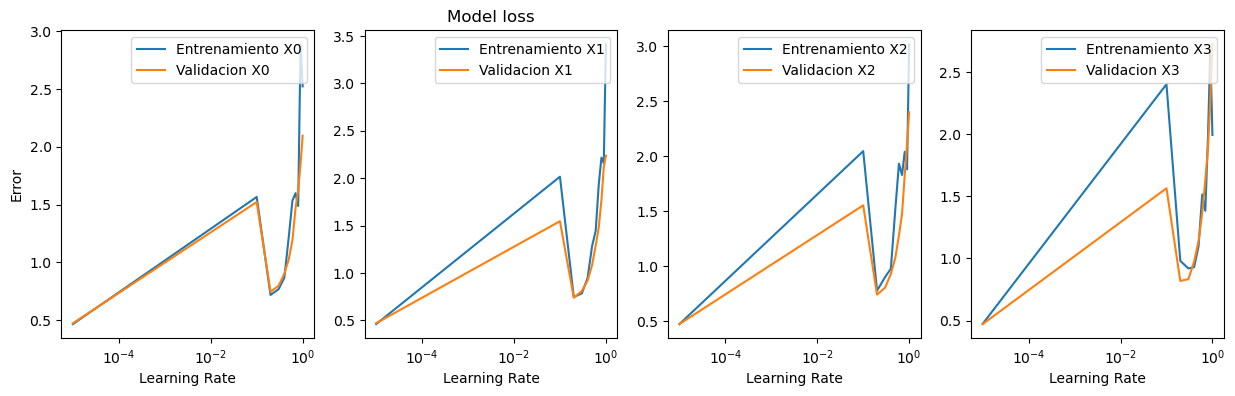

In [69]:
aux1 = [minLoss0_1,minLoss1_1, minLoss2_1, minLoss3_1]
aux2 = [minTrain0_1,minTrain1_1, minTrain2_1, minTrain3_1]
aux3 = ["X0","X1", "X2", "X3"]
fig, ax = plt.subplots(1, 4, figsize=(15,4),)

for i in range(len(aux1)):
    ax[i].plot(RegVal, aux1[i])
    ax[i].plot(RegVal, aux2[i])
    #ax[i].xticks(default_x_ticks, neuronas)
    ax[i].legend(['Entrenamiento ' +aux3[i] ,'Validacion '+aux3[i]], loc='upper right')
    #ax[i].set_ylim(0.4,0.6)
    ax[i].set_xscale("log")
    ax[i].set_xlabel('Learning Rate')

ax[1].set_title('Model loss')
ax[0].set_ylabel('Error')
plt.show()

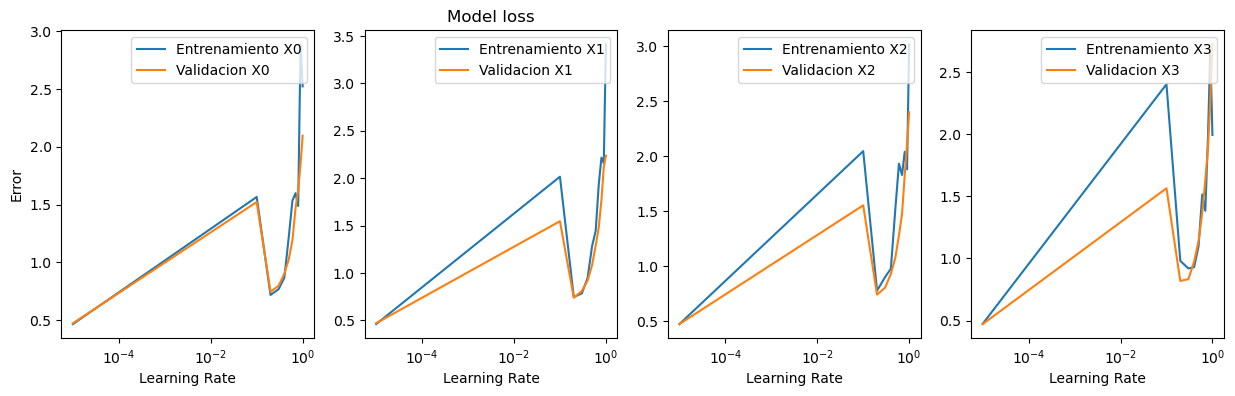

In [70]:
aux1 = [minLoss0_1,minLoss1_1, minLoss2_1, minLoss3_1]
aux2 = [minTrain0_1,minTrain1_1, minTrain2_1, minTrain3_1]
aux3 = ["X0","X1", "X2", "X3"]
fig, ax = plt.subplots(1, 4, figsize=(15,4),)

for i in range(len(aux1)):
    ax[i].plot(RegVal, aux1[i])
    ax[i].plot(RegVal, aux2[i])
    #ax[i].xticks(default_x_ticks, neuronas)
    ax[i].legend(['Entrenamiento ' +aux3[i] ,'Validacion '+aux3[i]], loc='upper right')
    #ax[i].set_ylim(0.4,0.6)
    ax[i].set_xscale("log")
    ax[i].set_xlabel('Learning Rate')

ax[1].set_title('Model loss')
ax[0].set_ylabel('Error')
plt.show()

In [71]:
regul= RegVal[0]
regul

1e-05

Los gráficos describen el cambio del error al modificar el regularizador para los distintos dataset. Se puede observar que el menor valor para los errores ocurren en el valor inicial de prueba del regularizador el cual corresponde a 1e-05


### Respuestas

Frente a un valor de regularizacion muy alto, se observa un peor rendimiento de la red neuronal en el sentido de que el gap entre la curva de validacion y de entrenamiento es muy grande, es decir se produce un overfitting

Caso contrario para un valor muy bajo, se observa un error muy alto en la red

0.0001 ->L1: Loss:0.53 ValLoss:0.54

       ->L2: Loss:0.50 ValLoss:0.52
       
0.002575 ->L1: Loss:0.65 ValLoss:0.69

       ->L2: Loss:0.61 ValLoss:0.66

0.00505 ->L1: Loss:0.78 ValLoss:0.86

       ->L2: Loss:0.73 ValLoss:0.82
       
0.007525 ->L1: Loss:0.8858 ValLoss:1.0056

       ->L2: Loss:0.8409 ValLoss:0.9661
       
0.001 ->L1: Loss:1.0117 ValLoss:1.1615

       ->L2: Loss:0.9527 ValLoss:1.1121

### Capa de salida

#### Dataset 0

In [72]:
print("\t Capa Salida L1")
model_reg = Salida1(learning_r,'tanh',regul)
history = model_reg.fit(x_tr_o, y_tr, epochs=20, validation_data=(x_val_o,y_val))
print("\t Capa Salida L2")
model_reg = Salida1(learning_r,'tanh',regul)
history = model_reg.fit(x_tr_o, y_tr, epochs=20, validation_data=(x_val_o,y_val))

	 Capa Salida L1
Epoch 1/20
17/17 [==============================] - 1s 25ms/step - loss: 0.6805 - val_loss: 0.6406
Epoch 2/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6273 - val_loss: 0.6041
Epoch 3/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5913 - val_loss: 0.5786
Epoch 4/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5658 - val_loss: 0.5595
Epoch 5/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5467 - val_loss: 0.5447
Epoch 6/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5329 - val_loss: 0.5329
Epoch 7/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5221 - val_loss: 0.5228
Epoch 8/20
17/17 [==============================] - 0s 7ms/step - loss: 0.5132 - val_loss: 0.5143
Epoch 9/20
17/17 [==============================] - 0s 9ms/step - loss: 0.5062 - val_loss: 0.5070
Epoch 10/20
17/17 [==============================] - 0s 7ms/step - loss: 0.5001 - val_loss: 0.5008
E

#### Dataset 1

In [73]:
# Capa salida l1
model_reg = Salida1(learning_r,'tanh',regul)
history = model_reg.fit(x_tr_1, y_tr, epochs=20, validation_data=(x_val_1,y_val))

Epoch 1/20
17/17 [==============================] - 2s 23ms/step - loss: 0.6677 - val_loss: 0.6611
Epoch 2/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6073 - val_loss: 0.5990
Epoch 3/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5693 - val_loss: 0.5609
Epoch 4/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5440 - val_loss: 0.5370
Epoch 5/20
17/17 [==============================] - 0s 7ms/step - loss: 0.5268 - val_loss: 0.5201
Epoch 6/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5142 - val_loss: 0.5085
Epoch 7/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5047 - val_loss: 0.4997
Epoch 8/20
17/17 [==============================] - 0s 6ms/step - loss: 0.4976 - val_loss: 0.4930
Epoch 9/20
17/17 [==============================] - 0s 6ms/step - loss: 0.4920 - val_loss: 0.4875
Epoch 10/20
17/17 [==============================] - 0s 6ms/step - loss: 0.4877 - val_loss: 0.4831
Epoch 11/20
17/17 

In [74]:
# Capa salida l2
model_reg = Salida1(learning_r,'tanh',regul)
history = model_reg.fit(x_tr_1, y_tr, epochs=20, validation_data=(x_val_1,y_val))

Epoch 1/20
17/17 [==============================] - 1s 22ms/step - loss: 0.7156 - val_loss: 0.6511
Epoch 2/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6381 - val_loss: 0.5900
Epoch 3/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5917 - val_loss: 0.5561
Epoch 4/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5615 - val_loss: 0.5365
Epoch 5/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5411 - val_loss: 0.5241
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5266 - val_loss: 0.5159
Epoch 7/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5161 - val_loss: 0.5099
Epoch 8/20
17/17 [==============================] - 0s 7ms/step - loss: 0.5081 - val_loss: 0.5053
Epoch 9/20
17/17 [==============================] - 0s 8ms/step - loss: 0.5016 - val_loss: 0.5014
Epoch 10/20
17/17 [==============================] - 0s 7ms/step - loss: 0.4967 - val_loss: 0.4983
Epoch 11/20
17/17 

#### Dataset 2

In [75]:
print("\t Capa Salida L1")
model_reg = Salida1(learning_r,'tanh',regul)
history = model_reg.fit(x_tr_2, y_tr, epochs=20, validation_data=(x_val_2,y_val))
print("\t Capa Salida L2")
model_reg = Salida1(learning_r,'tanh',regul)
history = model_reg.fit(x_tr_2, y_tr, epochs=20, validation_data=(x_val_2,y_val))

	 Capa Salida L1
Epoch 1/20
17/17 [==============================] - 1s 23ms/step - loss: 0.6851 - val_loss: 0.6300
Epoch 2/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6231 - val_loss: 0.5891
Epoch 3/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5838 - val_loss: 0.5633
Epoch 4/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5574 - val_loss: 0.5461
Epoch 5/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5386 - val_loss: 0.5336
Epoch 6/20
17/17 [==============================] - 0s 7ms/step - loss: 0.5249 - val_loss: 0.5239
Epoch 7/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5145 - val_loss: 0.5161
Epoch 8/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5064 - val_loss: 0.5098
Epoch 9/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5002 - val_loss: 0.5043
Epoch 10/20
17/17 [==============================] - 0s 6ms/step - loss: 0.4949 - val_loss: 0.4997
E

#### Dataset 3

In [76]:
print("\t Capa Salida L1")
model_reg = Salida1(learning_r,'tanh',regul)
history = model_reg.fit(x_tr_3, y_tr, epochs=20, validation_data=(x_val_3,y_val))
print("\t Capa Salida L2")
model_reg = Salida1(learning_r,'tanh',regul)
history = model_reg.fit(x_tr_3, y_tr, epochs=20, validation_data=(x_val_3,y_val))

	 Capa Salida L1
Epoch 1/20
17/17 [==============================] - 1s 22ms/step - loss: 0.6955 - val_loss: 0.6280
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6256 - val_loss: 0.5853
Epoch 3/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5837 - val_loss: 0.5592
Epoch 4/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5562 - val_loss: 0.5421
Epoch 5/20
17/17 [==============================] - 0s 8ms/step - loss: 0.5372 - val_loss: 0.5303
Epoch 6/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5237 - val_loss: 0.5215
Epoch 7/20
17/17 [==============================] - 0s 7ms/step - loss: 0.5136 - val_loss: 0.5145
Epoch 8/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5060 - val_loss: 0.5090
Epoch 9/20
17/17 [==============================] - 0s 7ms/step - loss: 0.4998 - val_loss: 0.5043
Epoch 10/20
17/17 [==============================] - 0s 6ms/step - loss: 0.4947 - val_loss: 0.5003
E

### Ambas capas

#### Dataset X0

In [77]:
print("\t Ambas capas L1")
model_reg = Ambas1(learning_r,'tanh',regul)

history = model_reg.fit(x_tr_o, y_tr, epochs=20, validation_data=(x_val_o,y_val))

print("\t Ambas capas L2")
model_reg = Ambas2(learning_r,'tanh',regul)
history = model_reg.fit(x_tr_o, y_tr, epochs=20, validation_data=(x_val_o,y_val))

	 Ambas capas L1
Epoch 1/20
17/17 [==============================] - 1s 27ms/step - loss: 0.7003 - val_loss: 0.6618
Epoch 2/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6373 - val_loss: 0.6158
Epoch 3/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5963 - val_loss: 0.5847
Epoch 4/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5681 - val_loss: 0.5626
Epoch 5/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5480 - val_loss: 0.5463
Epoch 6/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5333 - val_loss: 0.5333
Epoch 7/20
17/17 [==============================] - 0s 7ms/step - loss: 0.5215 - val_loss: 0.5229
Epoch 8/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5126 - val_loss: 0.5142
Epoch 9/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5055 - val_loss: 0.5069
Epoch 10/20
17/17 [==============================] - 0s 5ms/step - loss: 0.4997 - val_loss: 0.5004
E

#### Dataset X1

In [78]:
# Ambas capas l1
model_reg = Ambas1(learning_r,'tanh',regul)

history = model_reg.fit(x_tr_1, y_tr, epochs=20, validation_data=(x_val_1,y_val))

Epoch 1/20
17/17 [==============================] - 1s 25ms/step - loss: 0.7351 - val_loss: 0.6685
Epoch 2/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6479 - val_loss: 0.6005
Epoch 3/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5962 - val_loss: 0.5643
Epoch 4/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5642 - val_loss: 0.5434
Epoch 5/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5431 - val_loss: 0.5301
Epoch 6/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5281 - val_loss: 0.5207
Epoch 7/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5171 - val_loss: 0.5138
Epoch 8/20
17/17 [==============================] - 0s 7ms/step - loss: 0.5088 - val_loss: 0.5083
Epoch 9/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5024 - val_loss: 0.5037
Epoch 10/20
17/17 [==============================] - 0s 6ms/step - loss: 0.4971 - val_loss: 0.4997
Epoch 11/20
17/17 

In [79]:
# Ambas capas l2
model_reg = Ambas2(learning_r,'tanh',regul)
history = model_reg.fit(x_tr_1, y_tr, epochs=20, validation_data=(x_val_1,y_val))

Epoch 1/20
17/17 [==============================] - 2s 46ms/step - loss: 0.6436 - val_loss: 0.6113
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6005 - val_loss: 0.5837
Epoch 3/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5713 - val_loss: 0.5655
Epoch 4/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5511 - val_loss: 0.5525
Epoch 5/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5362 - val_loss: 0.5425
Epoch 6/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5246 - val_loss: 0.5345
Epoch 7/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5158 - val_loss: 0.5278
Epoch 8/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5084 - val_loss: 0.5216
Epoch 9/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5026 - val_loss: 0.5161
Epoch 10/20
17/17 [==============================] - 0s 5ms/step - loss: 0.4977 - val_loss: 0.5114
Epoch 11/20
17/17 

#### Dataset X2

In [80]:
print("\t Ambas capas L1")
model_reg = Ambas1(learning_r,'tanh',regul)

history = model_reg.fit(x_tr_2, y_tr, epochs=20, validation_data=(x_val_2,y_val))

print("\t Ambas capas L2")
model_reg = Ambas2(learning_r,'tanh',regul)
history = model_reg.fit(x_tr_2, y_tr, epochs=20, validation_data=(x_val_2,y_val))

	 Ambas capas L1
Epoch 1/20
17/17 [==============================] - 1s 26ms/step - loss: 0.6160 - val_loss: 0.6015
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5790 - val_loss: 0.5695
Epoch 3/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5543 - val_loss: 0.5480
Epoch 4/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5369 - val_loss: 0.5324
Epoch 5/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5239 - val_loss: 0.5205
Epoch 6/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5138 - val_loss: 0.5111
Epoch 7/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5063 - val_loss: 0.5035
Epoch 8/20
17/17 [==============================] - 0s 6ms/step - loss: 0.4999 - val_loss: 0.4971
Epoch 9/20
17/17 [==============================] - 0s 6ms/step - loss: 0.4947 - val_loss: 0.4918
Epoch 10/20
17/17 [==============================] - 0s 5ms/step - loss: 0.4907 - val_loss: 0.4870
E

#### Dataset X3

In [81]:
print("\t Ambas capas L1")
model_reg = Ambas1(learning_r,'tanh',regul)
history = model_reg.fit(x_tr_3, y_tr, epochs=20, validation_data=(x_val_3,y_val))

print("\t Ambas capas L2")
model_reg = Ambas2(learning_r,'tanh',regul)
history = model_reg.fit(x_tr_3, y_tr, epochs=20, validation_data=(x_val_3,y_val))

	 Ambas capas L1
Epoch 1/20
17/17 [==============================] - 1s 24ms/step - loss: 0.7063 - val_loss: 0.6447
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6246 - val_loss: 0.5946
Epoch 3/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5787 - val_loss: 0.5684
Epoch 4/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5511 - val_loss: 0.5532
Epoch 5/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5333 - val_loss: 0.5432
Epoch 6/20
17/17 [==============================] - 0s 7ms/step - loss: 0.5206 - val_loss: 0.5362
Epoch 7/20
17/17 [==============================] - 0s 8ms/step - loss: 0.5116 - val_loss: 0.5309
Epoch 8/20
17/17 [==============================] - 0s 7ms/step - loss: 0.5048 - val_loss: 0.5265
Epoch 9/20
17/17 [==============================] - 0s 6ms/step - loss: 0.4994 - val_loss: 0.5223
Epoch 10/20
17/17 [==============================] - 0s 6ms/step - loss: 0.4952 - val_loss: 0.5186
E

## 1.g Exploración del Número de neuronas

Ahora probaremos cambiando el número de neuronas en la capa oculta. Para esto, entrene la red con los hiperparámetros que estimen conveniente luego de la pregunta anterior, variando el numero de neuronas. Deben explorar a lo menos 10 número de neuronas distintos. Una recomendación sería por ejemplo explorar numero de neuronas en potencias de 2. 

Para cada red entrenada, recuperen el mejor error de validación y el error de entrenamiento en la _epoch_ donde se obtuvo tal error de validación. Grafique como se comportan ambos errores a medida crece el número de neuronas y comente. 

In [82]:
def modelo(n,lr,activation):
    model=Sequential()
    model.add(Dense(units = n, activation = activation))
    model.add(Dense(units = 1, activation='sigmoid'))
    model.compile(optimizer=SGD(learning_rate=lr),loss='binary_crossentropy')
    return model

### Dataset X0

In [83]:
train_erroro, val_erroro, neuronas = [], [],[]
k=1
for n_units in [2**(k), 2**(k+1), 2**(k+2), 2**(k+3),2**(k+4),2**(k+5),2**(k+6),2**(k+7),2**(k+8), 2**(k+9)]:
    model = modelo(n_units,learning_r,'tanh')
    history = model.fit(x_tr_o, y_tr, epochs=20, validation_data=(x_val_o,y_val))
    val_e = min(history.history['val_loss'])
    train_e = history.history['loss'][np.argmin(history.history['val_loss'])] 
    val_erroro.append(val_e)
    train_erroro.append(train_e)
    neuronas.append(n_units)

Epoch 1/20
17/17 [==============================] - 1s 21ms/step - loss: 0.6187 - val_loss: 0.6888
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6088 - val_loss: 0.6764
Epoch 3/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6001 - val_loss: 0.6652
Epoch 4/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5920 - val_loss: 0.6549
Epoch 5/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5847 - val_loss: 0.6455
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5780 - val_loss: 0.6368
Epoch 7/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5718 - val_loss: 0.6288
Epoch 8/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5661 - val_loss: 0.6215
Epoch 9/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5610 - val_loss: 0.6146
Epoch 10/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5560 - val_loss: 0.6082
Epoch 11/20
17/17 

### Dataset X1

In [84]:
train_error1, val_error1, neuronas = [], [],[]
k=1

for n_units in [2**(k), 2**(k+1), 2**(k+2), 2**(k+3),2**(k+4),2**(k+5),2**(k+6),2**(k+7),2**(k+8), 2**(k+9)]:
    model = modelo(n_units,learning_r,'tanh')
    history = model.fit(x_tr_1, y_tr, epochs=20, validation_data=(x_val_1,y_val))
    val_e = min(history.history['val_loss'])
    train_e = history.history['loss'][np.argmin(history.history['val_loss'])] 
    val_error1.append(val_e)
    train_error1.append(train_e)
    neuronas.append(n_units)

Epoch 1/20
17/17 [==============================] - 1s 28ms/step - loss: 0.6806 - val_loss: 0.6950
Epoch 2/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6634 - val_loss: 0.6770
Epoch 3/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6485 - val_loss: 0.6610
Epoch 4/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6354 - val_loss: 0.6470
Epoch 5/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6240 - val_loss: 0.6347
Epoch 6/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6141 - val_loss: 0.6238
Epoch 7/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6054 - val_loss: 0.6141
Epoch 8/20
17/17 [==============================] - 0s 5ms/step - loss: 0.5977 - val_loss: 0.6056
Epoch 9/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5908 - val_loss: 0.5979
Epoch 10/20
17/17 [==============================] - 0s 9ms/step - loss: 0.5846 - val_loss: 0.5910
Epoch 11/20
17/17 

### Dataset X2

In [85]:
train_error2, val_error2, neuronas = [], [],[]
k=1
for n_units in [2**(k), 2**(k+1), 2**(k+2), 2**(k+3),2**(k+4),2**(k+5),2**(k+6),2**(k+7),2**(k+8), 2**(k+9)]:
    model = modelo(n_units,learning_r,'tanh')
    history = model.fit(x_tr_2, y_tr, epochs=20, validation_data=(x_val_2,y_val))
    val_e = min(history.history['val_loss'])
    train_e = history.history['loss'][np.argmin(history.history['val_loss'])] 
    val_error2.append(val_e)
    train_error2.append(train_e)
    neuronas.append(n_units)

Epoch 1/20
17/17 [==============================] - 1s 23ms/step - loss: 0.6663 - val_loss: 0.6603
Epoch 2/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6609 - val_loss: 0.6538
Epoch 3/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6557 - val_loss: 0.6476
Epoch 4/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6508 - val_loss: 0.6417
Epoch 5/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6460 - val_loss: 0.6360
Epoch 6/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6413 - val_loss: 0.6306
Epoch 7/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6368 - val_loss: 0.6255
Epoch 8/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6325 - val_loss: 0.6205
Epoch 9/20
17/17 [==============================] - 0s 7ms/step - loss: 0.6283 - val_loss: 0.6158
Epoch 10/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6241 - val_loss: 0.6114
Epoch 11/20
17/17 

### Dataset X3

In [86]:
train_error3, val_error3, neuronas = [], [],[]
k=1
for n_units in [2**(k), 2**(k+1), 2**(k+2), 2**(k+3),2**(k+4),2**(k+5),2**(k+6),2**(k+7),2**(k+8), 2**(k+9)]:
    model = modelo(n_units,learning_r,'tanh')
    history = model.fit(x_tr_3, y_tr, epochs=20, validation_data=(x_val_3,y_val))
    val_e = min(history.history['val_loss'])
    train_e = history.history['loss'][np.argmin(history.history['val_loss'])] 
    val_error3.append(val_e)
    train_error3.append(train_e)
    neuronas.append(n_units)

Epoch 1/20
17/17 [==============================] - 1s 21ms/step - loss: 0.7768 - val_loss: 0.7675
Epoch 2/20
17/17 [==============================] - 0s 6ms/step - loss: 0.7649 - val_loss: 0.7548
Epoch 3/20
17/17 [==============================] - 0s 6ms/step - loss: 0.7539 - val_loss: 0.7431
Epoch 4/20
17/17 [==============================] - 0s 10ms/step - loss: 0.7438 - val_loss: 0.7322
Epoch 5/20
17/17 [==============================] - 0s 7ms/step - loss: 0.7344 - val_loss: 0.7221
Epoch 6/20
17/17 [==============================] - 0s 8ms/step - loss: 0.7257 - val_loss: 0.7127
Epoch 7/20
17/17 [==============================] - 0s 7ms/step - loss: 0.7178 - val_loss: 0.7040
Epoch 8/20
17/17 [==============================] - 0s 6ms/step - loss: 0.7103 - val_loss: 0.6959
Epoch 9/20
17/17 [==============================] - 0s 5ms/step - loss: 0.7034 - val_loss: 0.6883
Epoch 10/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6970 - val_loss: 0.6812
Epoch 11/20
17/17

### Graficos comparativos

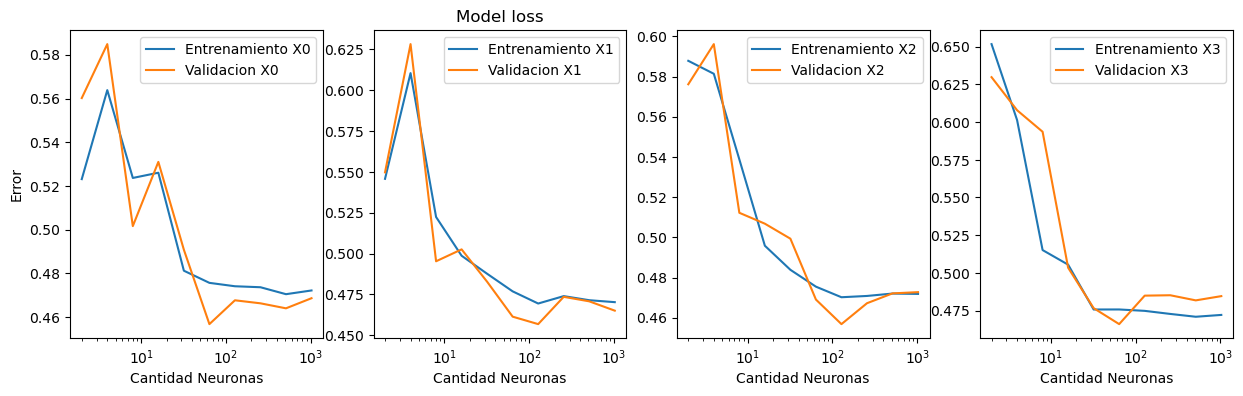

In [87]:
#default_x_ticks = range(len(neuronas))
default_x_ticks =  [2**(k), 2**(k+1), 2**(k+2), 2**(k+3),2**(k+4),2**(k+5),2**(k+6),2**(k+7),2**(k+8), 2**(k+9)]
aux1 = [train_erroro,train_error1, train_error2, train_error3]
aux2 = [val_erroro,val_error1, val_error2, val_error3]
aux3 = ["X0","X1", "X2", "X3"]
fig, ax = plt.subplots(1, 4, figsize=(15,4),)

for i in range(len(aux1)):
    ax[i].plot(default_x_ticks, aux1[i])
    ax[i].plot(default_x_ticks, aux2[i])
    #ax[i].xticks(default_x_ticks, neuronas)
    ax[i].legend(['Entrenamiento ' +aux3[i] ,'Validacion '+aux3[i]], loc='upper right')
    #ax[i].set_ylim(0.4,0.6)
    ax[i].set_xlabel('Cantidad Neuronas')
    ax[i].set_xscale("log")

ax[1].set_title('Model loss')
ax[0].set_ylabel('Error')
plt.show()

## 1.h Dropout
Como seguramente constataron en la pregunta anterior, un numero demasiado grande de parámetros en el modelo puede llevarnos a observar el fenomeno de _overfitting_. Una aproximación a este fenómeno que ha dado excelente resultado en redes neuronales es el método _dropout_, donde estocásticamente se desactivan una fracción de las neuronas al momento del entrenamiento, así efectivamente reduciendo el tamaño del modelo que se entrena en cada iteración e implicitamente obteniendo modelos más robustos por el simple hecho que al momento de entrenar nunca se entrena el "mismo" modelo. 

Según lo aprendido en el ramo, ¿en qué consiste el fenómeno de _overfitting_? ¿Por qué modelos más grandes suelen presentar el fenómeno? 

Entrene la mejor red obtenida en la pregunta anterior agregando una capa de _Dropout_ con parámetro $0.5$ inmediatamente luego de la capa oculta. Repita luego el proceso con una red con el doble de neuronas. Note que el agregar una capa _dropout_ hará que la red entrene más lento, por lo cual es recomendable aumentar el numero de _epochs_ para entrenar la red a completitud. 

¿Qué observa al agregar _dropout_? Comente y compare con sus resultados anteriores. 

In [88]:
def Drop(n,lr,activation):
    model=Sequential()
    model.add(Dense(units = n, activation = activation))
    model.add(Dropout(0.5))
    model.add(Dense(units = 1,activation='sigmoid'))
    model.compile(optimizer=SGD(learning_rate=lr),loss='binary_crossentropy')
    return model

### Dataset X0

In [89]:
modelo_1 = Drop(256,learning_r,'tanh')
    
historyo_1 = modelo_1.fit(x_tr_o, y_tr, epochs=50, validation_data=(x_val_o,y_val))

Epoch 1/50
17/17 [==============================] - 1s 22ms/step - loss: 0.7181 - val_loss: 0.6702
Epoch 2/50
17/17 [==============================] - 0s 6ms/step - loss: 0.6595 - val_loss: 0.6266
Epoch 3/50
17/17 [==============================] - 0s 5ms/step - loss: 0.6195 - val_loss: 0.5979
Epoch 4/50
17/17 [==============================] - 0s 5ms/step - loss: 0.5844 - val_loss: 0.5767
Epoch 5/50
17/17 [==============================] - 0s 7ms/step - loss: 0.5622 - val_loss: 0.5599
Epoch 6/50
17/17 [==============================] - 0s 7ms/step - loss: 0.5502 - val_loss: 0.5469
Epoch 7/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5334 - val_loss: 0.5355
Epoch 8/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5237 - val_loss: 0.5262
Epoch 9/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5127 - val_loss: 0.5186
Epoch 10/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5159 - val_loss: 0.5120
Epoch 11/50
17/17 

In [90]:
modelo_2 = Drop(256*2,learning_r,'tanh')
    
historyo_2 = modelo_2.fit(x_tr_1, y_tr, epochs=50, validation_data=(x_val_1,y_val))

Epoch 1/50
17/17 [==============================] - 1s 21ms/step - loss: 0.7051 - val_loss: 0.6395
Epoch 2/50
17/17 [==============================] - 0s 6ms/step - loss: 0.6237 - val_loss: 0.5847
Epoch 3/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5811 - val_loss: 0.5548
Epoch 4/50
17/17 [==============================] - 0s 7ms/step - loss: 0.5531 - val_loss: 0.5374
Epoch 5/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5347 - val_loss: 0.5260
Epoch 6/50
17/17 [==============================] - 0s 7ms/step - loss: 0.5241 - val_loss: 0.5173
Epoch 7/50
17/17 [==============================] - 0s 10ms/step - loss: 0.5166 - val_loss: 0.5105
Epoch 8/50
17/17 [==============================] - 0s 8ms/step - loss: 0.5062 - val_loss: 0.5050
Epoch 9/50
17/17 [==============================] - 0s 6ms/step - loss: 0.4926 - val_loss: 0.5004
Epoch 10/50
17/17 [==============================] - 0s 6ms/step - loss: 0.4871 - val_loss: 0.4966
Epoch 11/50
17/17

### Dataset X1

In [91]:
model1_1 = Drop(256,learning_r,'tanh')
    
history1_1 = model1_1.fit(x_tr_1, y_tr, epochs=50, validation_data=(x_val_1,y_val))

Epoch 1/50
17/17 [==============================] - 1s 23ms/step - loss: 0.6413 - val_loss: 0.6156
Epoch 2/50
17/17 [==============================] - 0s 8ms/step - loss: 0.5939 - val_loss: 0.5843
Epoch 3/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5785 - val_loss: 0.5625
Epoch 4/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5653 - val_loss: 0.5459
Epoch 5/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5306 - val_loss: 0.5336
Epoch 6/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5290 - val_loss: 0.5235
Epoch 7/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5172 - val_loss: 0.5157
Epoch 8/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5161 - val_loss: 0.5090
Epoch 9/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5092 - val_loss: 0.5027
Epoch 10/50
17/17 [==============================] - 0s 8ms/step - loss: 0.4973 - val_loss: 0.4980
Epoch 11/50
17/17 

In [92]:
model1_2 = Drop(256*2,learning_r,'tanh')
    
history1_2 = model1_2.fit(x_tr_1, y_tr, epochs=50, validation_data=(x_val_1,y_val))

Epoch 1/50
17/17 [==============================] - 1s 22ms/step - loss: 0.6878 - val_loss: 0.6558
Epoch 2/50
17/17 [==============================] - 0s 6ms/step - loss: 0.6248 - val_loss: 0.5961
Epoch 3/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5776 - val_loss: 0.5625
Epoch 4/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5519 - val_loss: 0.5426
Epoch 5/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5408 - val_loss: 0.5285
Epoch 6/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5271 - val_loss: 0.5182
Epoch 7/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5183 - val_loss: 0.5108
Epoch 8/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5069 - val_loss: 0.5044
Epoch 9/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5026 - val_loss: 0.4992
Epoch 10/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5053 - val_loss: 0.4944
Epoch 11/50
17/17 

### Dataset X2

In [93]:
model2_1 = Drop(256,learning_r,'tanh')
    
history2_1 = model2_1.fit(x_tr_2, y_tr, epochs=50, validation_data=(x_val_2,y_val))

Epoch 1/50
17/17 [==============================] - 1s 20ms/step - loss: 0.6424 - val_loss: 0.6157
Epoch 2/50
17/17 [==============================] - 0s 5ms/step - loss: 0.6047 - val_loss: 0.5815
Epoch 3/50
17/17 [==============================] - 0s 5ms/step - loss: 0.5894 - val_loss: 0.5595
Epoch 4/50
17/17 [==============================] - 0s 5ms/step - loss: 0.5625 - val_loss: 0.5444
Epoch 5/50
17/17 [==============================] - 0s 5ms/step - loss: 0.5493 - val_loss: 0.5328
Epoch 6/50
17/17 [==============================] - 0s 5ms/step - loss: 0.5354 - val_loss: 0.5236
Epoch 7/50
17/17 [==============================] - 0s 5ms/step - loss: 0.5143 - val_loss: 0.5164
Epoch 8/50
17/17 [==============================] - 0s 5ms/step - loss: 0.5239 - val_loss: 0.5102
Epoch 9/50
17/17 [==============================] - 0s 5ms/step - loss: 0.5096 - val_loss: 0.5050
Epoch 10/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5092 - val_loss: 0.5002
Epoch 11/50
17/17 

In [94]:
model2_2 = Drop(256*2,learning_r,'tanh')
    
history2_2 = model2_2.fit(x_tr_2, y_tr, epochs=50, validation_data=(x_val_2,y_val))

Epoch 1/50
17/17 [==============================] - 1s 22ms/step - loss: 0.6939 - val_loss: 0.6335
Epoch 2/50
17/17 [==============================] - 0s 5ms/step - loss: 0.6240 - val_loss: 0.5825
Epoch 3/50
17/17 [==============================] - 0s 5ms/step - loss: 0.5815 - val_loss: 0.5543
Epoch 4/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5557 - val_loss: 0.5370
Epoch 5/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5389 - val_loss: 0.5257
Epoch 6/50
17/17 [==============================] - 0s 5ms/step - loss: 0.5229 - val_loss: 0.5175
Epoch 7/50
17/17 [==============================] - 0s 5ms/step - loss: 0.5047 - val_loss: 0.5113
Epoch 8/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5100 - val_loss: 0.5056
Epoch 9/50
17/17 [==============================] - 0s 5ms/step - loss: 0.5016 - val_loss: 0.5008
Epoch 10/50
17/17 [==============================] - 0s 5ms/step - loss: 0.4987 - val_loss: 0.4960
Epoch 11/50
17/17 

### Dataset X3

In [95]:
model3_1 = Drop(256,learning_r,'tanh')
    
history3_1 = model3_1.fit(x_tr_3, y_tr, epochs=50, validation_data=(x_val_3,y_val))

Epoch 1/50
17/17 [==============================] - 1s 24ms/step - loss: 0.6580 - val_loss: 0.6079
Epoch 2/50
17/17 [==============================] - 0s 7ms/step - loss: 0.6027 - val_loss: 0.5779
Epoch 3/50
17/17 [==============================] - 0s 7ms/step - loss: 0.5788 - val_loss: 0.5601
Epoch 4/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5722 - val_loss: 0.5487
Epoch 5/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5353 - val_loss: 0.5405
Epoch 6/50
17/17 [==============================] - 0s 5ms/step - loss: 0.5311 - val_loss: 0.5339
Epoch 7/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5232 - val_loss: 0.5283
Epoch 8/50
17/17 [==============================] - 0s 5ms/step - loss: 0.5035 - val_loss: 0.5239
Epoch 9/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5078 - val_loss: 0.5201
Epoch 10/50
17/17 [==============================] - 0s 5ms/step - loss: 0.5166 - val_loss: 0.5170
Epoch 11/50
17/17 

In [96]:
model3_2 = Drop(256*2,learning_r,'tanh')
    
history3_2 = model3_2.fit(x_tr_3, y_tr, epochs=50, validation_data=(x_val_3,y_val))

Epoch 1/50
17/17 [==============================] - 1s 22ms/step - loss: 0.7053 - val_loss: 0.6422
Epoch 2/50
17/17 [==============================] - 0s 6ms/step - loss: 0.6280 - val_loss: 0.5933
Epoch 3/50
17/17 [==============================] - 0s 9ms/step - loss: 0.5837 - val_loss: 0.5681
Epoch 4/50
17/17 [==============================] - 0s 5ms/step - loss: 0.5573 - val_loss: 0.5538
Epoch 5/50
17/17 [==============================] - 0s 7ms/step - loss: 0.5401 - val_loss: 0.5445
Epoch 6/50
17/17 [==============================] - 0s 5ms/step - loss: 0.5234 - val_loss: 0.5382
Epoch 7/50
17/17 [==============================] - 0s 5ms/step - loss: 0.5216 - val_loss: 0.5324
Epoch 8/50
17/17 [==============================] - 0s 5ms/step - loss: 0.5033 - val_loss: 0.5277
Epoch 9/50
17/17 [==============================] - 0s 5ms/step - loss: 0.5044 - val_loss: 0.5240
Epoch 10/50
17/17 [==============================] - 0s 5ms/step - loss: 0.4902 - val_loss: 0.5207
Epoch 11/50
17/17 

### Graficos comparativos

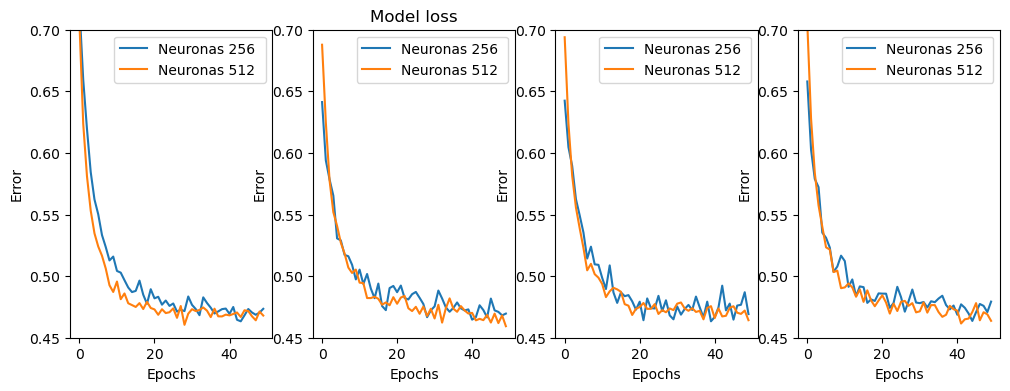

In [97]:
default_x_ticks = range(50)

fig, ax = plt.subplots(1, 4, figsize=(12,4),)

ax[0].set_ylim(0.45,0.7)
ax[1].set_ylim(0.45,0.7)
ax[2].set_ylim(0.45,0.7)
ax[3].set_ylim(0.45,0.7)
ax[0].plot(default_x_ticks, historyo_1.history['loss'])
ax[1].plot(default_x_ticks, history1_1.history['loss'])
ax[2].plot(default_x_ticks, history2_1.history['loss'])
ax[3].plot(default_x_ticks, history3_1.history['loss'])

ax[0].plot(default_x_ticks, historyo_2.history['loss'])
ax[1].plot(default_x_ticks, history1_2.history['loss'])
ax[2].plot(default_x_ticks, history2_2.history['loss'])
ax[3].plot(default_x_ticks, history3_2.history['loss'])

ax[1].set_title('Model loss')
ax[0].set_ylabel('Error')
ax[1].set_ylabel('Error')
ax[2].set_ylabel('Error')
ax[3].set_ylabel('Error')
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[2].set_xlabel('Epochs')
ax[3].set_xlabel('Epochs')

ax[0].legend(['Neuronas 256' ,'Neuronas 512 '], loc='upper right')
ax[1].legend(['Neuronas 256' ,'Neuronas 512 '], loc='upper right')
ax[2].legend(['Neuronas 256' ,'Neuronas 512 '], loc='upper right')
ax[3].legend(['Neuronas 256' ,'Neuronas 512 '], loc='upper right')


plt.show()

### Respuestas

El overfitting es un fenomeno en que la red aprende muy bien el conjunto de datos pero al momento de usar datos nuevos la prediccion es muy mala.

Un fenomeno que se puede observar en comparacion a los graficos anteriores es que las curvas entre la prediccion de entrenamiento y la de validacion son similares (el gap entre ellas es pequeño), lo que quiere decir que el modelo esta "prediciendo correctamente", por otro lado, vemos una tendencia en la reduccion del error.

## 1.i Learning Rate Decay
Ahora entrenaremos un modelo manejando manualmente el _learn rate_. Para esto utilizaremos el _callback_ `LearningRateScheduler`. Este _callback_ nos permitirá implementar una función que maneje el _learn rate_ de nuestro modelo. 

Escriba una función que reciba la epoca actual y retorne un _learn rate_ lr. El lr inicial debe ser igual o mayor a alguno que haya dado buenos resultados en las preguntas anteriores. La función debe dividir por 2 el lr cada 10 _epochs_. Además ponga como restricción que el lr no debe ser menor a $5\times 10^{-5}$, es decir si el valor obtenido es menor a  $5\times 10^{-5}$, la función retorna  $5\times 10^{-5}$.

Entrene su red preferida de las preguntas anteriores con esta modificación, grafique los errores a lo largo del entrenamiento y comente. Según lo visto en el ramo, ¿por qué podría ser util disminuir el _learn rate_ a medida se avanza en el aprendizaje de la red?

In [98]:
def step_decay(epoch,lr):
    if epoch%10==0:
        lr=lr/2
    if lr<= 5*(10**(-5)):
        lr= 5*(10**(-5))
    return lr

### Dataset X0

In [99]:
schedule1 = LearningRateScheduler(step_decay)
modelo = Drop(256,learning_r,'tanh')
historyo = modelo.fit(x_tr_o, y_tr, epochs=60, validation_data=(x_val_o,y_val),callbacks=[schedule1])

Epoch 1/60
17/17 [==============================] - 1s 20ms/step - loss: 0.6855 - val_loss: 0.6604 - lr: 0.0045
Epoch 2/60
17/17 [==============================] - 0s 5ms/step - loss: 0.6405 - val_loss: 0.6362 - lr: 0.0045
Epoch 3/60
17/17 [==============================] - 0s 7ms/step - loss: 0.6260 - val_loss: 0.6158 - lr: 0.0045
Epoch 4/60
17/17 [==============================] - 0s 7ms/step - loss: 0.6234 - val_loss: 0.5984 - lr: 0.0045
Epoch 5/60
17/17 [==============================] - 0s 6ms/step - loss: 0.5919 - val_loss: 0.5846 - lr: 0.0045
Epoch 6/60
17/17 [==============================] - 0s 5ms/step - loss: 0.5723 - val_loss: 0.5727 - lr: 0.0045
Epoch 7/60
17/17 [==============================] - 0s 6ms/step - loss: 0.5692 - val_loss: 0.5628 - lr: 0.0045
Epoch 8/60
17/17 [==============================] - 0s 5ms/step - loss: 0.5633 - val_loss: 0.5541 - lr: 0.0045
Epoch 9/60
17/17 [==============================] - 0s 5ms/step - loss: 0.5442 - val_loss: 0.5466 - lr: 0.0045


### Dataset X1

In [100]:
schedule1 = LearningRateScheduler(step_decay)
model1 = Drop(256,learning_r,'tanh')
history1 = model1.fit(x_tr_1, y_tr, epochs=60, validation_data=(x_val_1,y_val),callbacks=[schedule1])

Epoch 1/60
17/17 [==============================] - 1s 25ms/step - loss: 0.7063 - val_loss: 0.6777 - lr: 0.0045
Epoch 2/60
17/17 [==============================] - 0s 8ms/step - loss: 0.6653 - val_loss: 0.6382 - lr: 0.0045
Epoch 3/60
17/17 [==============================] - 0s 9ms/step - loss: 0.6367 - val_loss: 0.6093 - lr: 0.0045
Epoch 4/60
17/17 [==============================] - 0s 8ms/step - loss: 0.6200 - val_loss: 0.5872 - lr: 0.0045
Epoch 5/60
17/17 [==============================] - 0s 7ms/step - loss: 0.5979 - val_loss: 0.5706 - lr: 0.0045
Epoch 6/60
17/17 [==============================] - 0s 7ms/step - loss: 0.5887 - val_loss: 0.5574 - lr: 0.0045
Epoch 7/60
17/17 [==============================] - 0s 7ms/step - loss: 0.5664 - val_loss: 0.5473 - lr: 0.0045
Epoch 8/60
17/17 [==============================] - 0s 8ms/step - loss: 0.5462 - val_loss: 0.5390 - lr: 0.0045
Epoch 9/60
17/17 [==============================] - 0s 8ms/step - loss: 0.5525 - val_loss: 0.5322 - lr: 0.0045


### Dataset X2

In [101]:
schedule2 = LearningRateScheduler(step_decay)
model2 = Drop(256,learning_r,'tanh')
history2 = model2.fit(x_tr_2, y_tr, epochs=60, validation_data=(x_val_2,y_val),callbacks=[schedule2])

Epoch 1/60
17/17 [==============================] - 1s 20ms/step - loss: 0.7232 - val_loss: 0.7424 - lr: 0.0045
Epoch 2/60
17/17 [==============================] - 0s 5ms/step - loss: 0.6800 - val_loss: 0.6850 - lr: 0.0045
Epoch 3/60
17/17 [==============================] - 0s 6ms/step - loss: 0.6438 - val_loss: 0.6432 - lr: 0.0045
Epoch 4/60
17/17 [==============================] - 0s 6ms/step - loss: 0.6176 - val_loss: 0.6116 - lr: 0.0045
Epoch 5/60
17/17 [==============================] - 0s 5ms/step - loss: 0.5932 - val_loss: 0.5892 - lr: 0.0045
Epoch 6/60
17/17 [==============================] - 0s 6ms/step - loss: 0.5733 - val_loss: 0.5706 - lr: 0.0045
Epoch 7/60
17/17 [==============================] - 0s 7ms/step - loss: 0.5667 - val_loss: 0.5556 - lr: 0.0045
Epoch 8/60
17/17 [==============================] - 0s 7ms/step - loss: 0.5577 - val_loss: 0.5439 - lr: 0.0045
Epoch 9/60
17/17 [==============================] - 0s 6ms/step - loss: 0.5382 - val_loss: 0.5348 - lr: 0.0045


### Dataset X3

In [102]:
schedule3 = LearningRateScheduler(step_decay)
model3 = Drop(256,learning_r,'tanh')
history3 = model3.fit(x_tr_3, y_tr, epochs=60, validation_data=(x_val_3,y_val),callbacks=[schedule3])

Epoch 1/60
17/17 [==============================] - 1s 20ms/step - loss: 0.6733 - val_loss: 0.6391 - lr: 0.0045
Epoch 2/60
17/17 [==============================] - 0s 5ms/step - loss: 0.6276 - val_loss: 0.6088 - lr: 0.0045
Epoch 3/60
17/17 [==============================] - 0s 5ms/step - loss: 0.6030 - val_loss: 0.5863 - lr: 0.0045
Epoch 4/60
17/17 [==============================] - 0s 5ms/step - loss: 0.5849 - val_loss: 0.5701 - lr: 0.0045
Epoch 5/60
17/17 [==============================] - 0s 5ms/step - loss: 0.5549 - val_loss: 0.5584 - lr: 0.0045
Epoch 6/60
17/17 [==============================] - 0s 5ms/step - loss: 0.5498 - val_loss: 0.5500 - lr: 0.0045
Epoch 7/60
17/17 [==============================] - 0s 5ms/step - loss: 0.5361 - val_loss: 0.5430 - lr: 0.0045
Epoch 8/60
17/17 [==============================] - 0s 6ms/step - loss: 0.5440 - val_loss: 0.5373 - lr: 0.0045
Epoch 9/60
17/17 [==============================] - 0s 5ms/step - loss: 0.5445 - val_loss: 0.5328 - lr: 0.0045


### Graficos comparativos

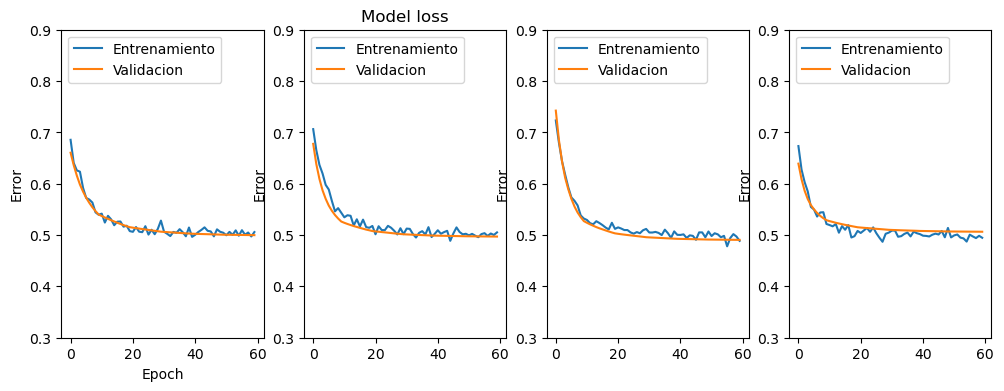

In [103]:
fig, ax = plt.subplots(1, 4, figsize=(12,4),)
aux = [historyo,history1, history2, history3]

for i in range(4):
    ax[i].set_ylim(0.3,0.9)
    ax[i].plot(range(60), aux[i].history['loss'])
    ax[i].plot(range(60), aux[i].history['val_loss'])
    ax[i].set_ylabel('Error')
    ax[0].set_xlabel('Epoch')
    ax[i].legend(['Entrenamiento', 'Validacion'], loc='upper left')

ax[1].set_title('Model loss')

plt.show()

### Respuestas

Disminuir el lerning rate nos ayuda a asegurar una convergencia de la red a un minimo, esto es porque con un valor muy alto, los saltos que realiza la red en busca del minimo son muy grandes y puede saltarse muchos minimos en el camino, por otro lado con un valor muy pequeño, el algoritmo tardara mucho en alcanzar el minimo, por ello es que se utiliza un ajuste del learning rate dinamico, donde a medida que avanzamos en las epocas, disminuimos su valor ya que en cada epoca estaremos cerca del minimo y por lo tanto no sera necesario dar pasos tan grandes.

## 1.j Vanishing Gradient

`Nota:` para esta y las siguientes preguntas solo considere el mejor conjunto de entrenamiento obtenidos a partir de la imputación, es decir, escoja el $X \in \{X_1, X_2, X_3\}$ con el que mejores resultados haya obtenido hasta ahora.

El fenómeno del _vanishing gradient_ es el rápido decaimiento del paso de _Backpropagation_ al avanzar por las capas. A lo largo de la tarea solo hemos entrenado capas con una red oculta, de igual forma que la comunidad cientifica realizo por largo tiempo, por el problema del _vanishing gradient_ y por el teorema de aproximación universal que resumidamente demuestra que una red de una sola capa puede aproximar una amplia familia de funciones. 

En esta pregunta entrenaremos una red neuronal profunda sin implementar ninguno de los dispositivos que permiten hoy en día sortear el problema del _vanishing gradient_, para ponerlo en evidencia. Para esto construya una red con 6 capas ocultas, con la siguiente lista de numero de neuronas: $256$ $256$ $128$ $128$ $32$ y $32$, o con valores similares. De tal manera obtendrá un valor de parámetros relativamente comparable a los valores utilizados en las primeras redes. 

Grafique un histograma con los pesos de las 6 capas densas de la red sin entrenar, entrenela a completitud con el método que estime conveniente y luego grafique nuevamente los histogramas para las 6 capas. Comente lo que observa. 

Luego, pruebe cambiar la inizialización de los pesos de la capa densa, puede revisar la documentación de keras para ver las opciones existentes a parte de `glorot_uniform` por defecto. ¿Se logra solucionar el problema? 

Por último, pruebe aumentar la tasa de aprendizaje para ver si logra hacer que el paso de _backpropagation_ alcance las capas que anteriormente no se entrenaban. ¿Qué observa en este caso? 

In [104]:
def VG(lr, activation, initializer):
    model=Sequential()
    # Hidden Layer
    model.add(Dense(units = 256, activation = activation,kernel_initializer=initializer))
    model.add(Dense(units = 256, activation = activation, kernel_initializer=initializer))
    model.add(Dense(units = 128, activation = activation, kernel_initializer=initializer))
    model.add(Dense(units = 128, activation = activation, kernel_initializer=initializer))
    model.add(Dense(units = 32, activation = activation, kernel_initializer=initializer))
    model.add(Dense(units = 32, activation = activation, kernel_initializer=initializer))
    # Output Layer
    model.add(Dense(units = 1,activation='sigmoid'))
    model.compile(optimizer=SGD(learning_rate=lr),loss='binary_crossentropy')
    return model

In [ ]:
init = tf.keras.initializers.glorot_uniform()
model=VG(0.02,'tanh', init)

### Grafico sin entrenar

### Gráfico entrenado

In [ ]:
history1 = model.fit(x_tr_1, y_tr, epochs=30, validation_data=(x_val_1,y_val))

In [ ]:
fig, ax = plt.subplots(6, 2, figsize=(10,18),)
for i in range(6):
    ax[i,0].hist(model.get_layer(index=i).get_weights()[0])
    ax[i,1].hist(model.get_layer(index=i).get_weights()[1])

### Diferentes inializadores

In [ ]:
model=VG(learning_r,'tanh', tf.keras.initializers.glorot_uniform())
history1 = model.fit(x_tr_1, y_tr, epochs=30, validation_data=(x_val_1,y_val))

In [ ]:
fig, ax = plt.subplots(6, 2, figsize=(10,18),)
for i in range(6):
    ax[i,0].hist(model.get_layer(index=i).get_weights()[0])
    ax[i,1].hist(model.get_layer(index=i).get_weights()[1])

In [ ]:
model=VG(0.02,'tanh',tf.keras.initializers.HeNormal())
history1 = model.fit(x_tr_1, y_tr, epochs=30, validation_data=(x_val_1,y_val))

In [ ]:
fig, ax = plt.subplots(6, 2, figsize=(10,18),)
for i in range(6):
    ax[i,0].hist(model.get_layer(index=i).get_weights()[0])
    ax[i,1].hist(model.get_layer(index=i).get_weights()[1])

In [ ]:
model=VG(0.02,'tanh', tf.keras.initializers.LecunNormal())
history1 = model.fit(x_tr_1, y_tr, epochs=30, validation_data=(x_val_1,y_val))

In [ ]:
fig, ax = plt.subplots(6, 2, figsize=(10,18),)
for i in range(6):
    ax[i,0].hist(model.get_layer(index=i).get_weights()[0])
    ax[i,1].hist(model.get_layer(index=i).get_weights()[1])

### Aumentar la tasa de aprendizaje

In [ ]:
init = tf.keras.initializers.glorot_uniform()
model=VG(0.05,'tanh', init)
history1 = model.fit(x_tr_1, y_tr, epochs=30, validation_data=(x_val_1,y_val))

### Respuestas
Al aumentar el learning rate, se observa un mejor rendimiento en el conjunto de entrenamiento pero peor en el conjunto de validacion. Es decir, se observa un fenomeno de overfitting

## 1.k Batch Normalization

Una manera propuesta de mejorar los desempeños de las redes es Batch Normalization. Entrene nuevamente su red preferida de la pregunta anterior, agregando capas de _Batch Normalization_ antes de cada función de activación. Comente sus resultados. Luego pruebe agregando capas de _Batch Normalization_ después de cada función de activación.

¿Qué realiza _Batch Normalization_ en términos matemáticos?. En términos de aprendizaje, ¿Qué evita la utilización de _Batch Normalization_?

¿Mejoran los desempeños de la red agregando _Batch Normalization_?¿Existe diferencias entre una capa de _Batch Normalization_ justo antes o justo después de la función de activación en términos de aprendizaje? Discuta.

In [105]:
from tensorflow.keras.layers import BatchNormalization

In [106]:
def BND(lr,activation):
    model=Sequential()
    # Hidden Layer
    model.add(Dense(units = 256, activation = activation))
    model.add(BatchNormalization())
    model.add(Dense(units = 256, activation = activation))
    model.add(BatchNormalization())
    model.add(Dense(units = 128, activation = activation))
    model.add(BatchNormalization())
    model.add(Dense(units = 128, activation = activation))
    model.add(BatchNormalization())
    model.add(Dense(units = 32, activation = activation))
    model.add(BatchNormalization())
    model.add(Dense(units = 32, activation = activation))
    model.add(BatchNormalization())
    # Output Layer
    model.add(
        Dense(
           units = 1,
           activation='sigmoid'
        )
    )

    model.compile(
        optimizer=SGD(learning_rate=lr),
        loss='binary_crossentropy'
    )
    return model

def BNA(lr,activation):
    model=Sequential()
    # Hidden Layer
    model.add(BatchNormalization())
    model.add(Dense(units = 256, activation = activation))
    model.add(BatchNormalization())
    model.add(Dense(units = 256, activation = activation))
    model.add(BatchNormalization())
    model.add(Dense(units = 128, activation = activation))
    model.add(BatchNormalization())
    model.add(Dense(units = 128, activation = activation))
    model.add(BatchNormalization())
    model.add(Dense(units = 32, activation = activation))
    model.add(BatchNormalization())
    model.add(Dense(units = 32, activation = activation))
    # Output Layer
    model.add(
        Dense(
           units = 1,
           activation='sigmoid'
        )
    )

    model.compile(
        optimizer=SGD(learning_rate=lr),
        loss='binary_crossentropy'
    )
    return model

In [107]:
model=BNA(learning_r,'tanh')

history = model.fit(x_tr_1, y_tr, epochs=30, validation_data=(x_val_1,y_val))

Epoch 1/30
17/17 [==============================] - 5s 41ms/step - loss: 0.5630 - val_loss: 0.5853
Epoch 2/30
17/17 [==============================] - 0s 8ms/step - loss: 0.5086 - val_loss: 0.5610
Epoch 3/30
17/17 [==============================] - 0s 9ms/step - loss: 0.5096 - val_loss: 0.5546
Epoch 4/30
17/17 [==============================] - 0s 10ms/step - loss: 0.4834 - val_loss: 0.5453
Epoch 5/30
17/17 [==============================] - 0s 10ms/step - loss: 0.4754 - val_loss: 0.5363
Epoch 6/30
17/17 [==============================] - 0s 8ms/step - loss: 0.4420 - val_loss: 0.5286
Epoch 7/30
17/17 [==============================] - 0s 8ms/step - loss: 0.4467 - val_loss: 0.5256
Epoch 8/30
17/17 [==============================] - 0s 10ms/step - loss: 0.4450 - val_loss: 0.5126
Epoch 9/30
17/17 [==============================] - 0s 10ms/step - loss: 0.4466 - val_loss: 0.5132
Epoch 10/30
17/17 [==============================] - 0s 13ms/step - loss: 0.4364 - val_loss: 0.5127
Epoch 11/30
1

In [108]:
model=BND(learning_r,'tanh')
history = model.fit(x_tr_1, y_tr, epochs=30, validation_data=(x_val_1,y_val))

Epoch 1/30
17/17 [==============================] - 3s 31ms/step - loss: 0.6265 - val_loss: 0.5886
Epoch 2/30
17/17 [==============================] - 0s 8ms/step - loss: 0.5376 - val_loss: 0.5664
Epoch 3/30
17/17 [==============================] - 0s 8ms/step - loss: 0.4913 - val_loss: 0.5501
Epoch 4/30
17/17 [==============================] - 0s 8ms/step - loss: 0.4941 - val_loss: 0.5394
Epoch 5/30
17/17 [==============================] - 0s 9ms/step - loss: 0.4726 - val_loss: 0.5328
Epoch 6/30
17/17 [==============================] - 0s 9ms/step - loss: 0.4344 - val_loss: 0.5262
Epoch 7/30
17/17 [==============================] - 0s 8ms/step - loss: 0.4261 - val_loss: 0.5122
Epoch 8/30
17/17 [==============================] - 0s 8ms/step - loss: 0.4195 - val_loss: 0.5103
Epoch 9/30
17/17 [==============================] - 0s 8ms/step - loss: 0.4040 - val_loss: 0.4979
Epoch 10/30
17/17 [==============================] - 0s 19ms/step - loss: 0.3858 - val_loss: 0.5037
Epoch 11/30
17/17

### Respuestas
Al agregar esta capa de batch normalization se observa un mejor rendimiento en el conjunto de entrenamiento pero un peor rendimiento en el conjunto de validacion, por lo tanto agregar esta capa genera un fenomeno de overfitting.

...


## 1.l Otros Optimizadores

Utilizando la arquitectura de red que mejor se haya desempeñado a lo largo de la tarea, entrene esta red utilizando un optimizador distinto al gradiente descendente estocástico. Pruebe al menos 2 optimizadores implementados en keras (puede utilizar Adam, AdaGrad, AdaDelta, RMSprop, entre otros), también puede probar modificando los parámetros que no hemos utilizado del gradiente descendente estocástico (momentum, momentum de Nesterov...).

Note que por las inicializaciones por defecto de los pesos de las capas y la naturaleza de los datos en cuestión, puede ocurrir que para los valores defecto de algunos optimizadores la red diverga en las primeras iteraciones. Para fijar los parámeros de los optimizadores debe importarlos desde `keras.optimizers` y pasar el objeto con los parámetros deseados al método `.compile` de su modelo. En cambio si con los valores usuales basta, algunos optimizadores pueden pasarse como `string` a `.compile`.

Compare como se desempeñan estos optimizadores con la versión utilizada anteriormente, considerando los tiempos de entrenamiento y el desempeño final alcanzado. Apoyese de gráficos. 

In [109]:
historyloss = []

In [110]:
%%time
model= Drop(256,learning_r,'tanh')
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam())
history = model.fit(x_tr_1, y_tr, epochs=60, validation_data=(x_val_1,y_val))
historyloss.append( history )

Epoch 1/60
17/17 [==============================] - 1s 23ms/step - loss: 0.6385 - val_loss: 0.5449
Epoch 2/60
17/17 [==============================] - 0s 7ms/step - loss: 0.5095 - val_loss: 0.5195
Epoch 3/60
17/17 [==============================] - 0s 5ms/step - loss: 0.4883 - val_loss: 0.4864
Epoch 4/60
17/17 [==============================] - 0s 5ms/step - loss: 0.4810 - val_loss: 0.4693
Epoch 5/60
17/17 [==============================] - 0s 6ms/step - loss: 0.4846 - val_loss: 0.4582
Epoch 6/60
17/17 [==============================] - 0s 6ms/step - loss: 0.4672 - val_loss: 0.4492
Epoch 7/60
17/17 [==============================] - 0s 6ms/step - loss: 0.4788 - val_loss: 0.4510
Epoch 8/60
17/17 [==============================] - 0s 6ms/step - loss: 0.4714 - val_loss: 0.4477
Epoch 9/60
17/17 [==============================] - 0s 6ms/step - loss: 0.4789 - val_loss: 0.4446
Epoch 10/60
17/17 [==============================] - 0s 6ms/step - loss: 0.4678 - val_loss: 0.4445
Epoch 11/60
17/17 

In [111]:
%%time
model= Drop(256,learning_r,'tanh')
model.compile(loss='binary_crossentropy', optimizer= tf.keras.optimizers.Adadelta())
history = model.fit(x_tr_1, y_tr, epochs=60, validation_data=(x_val_1,y_val))
historyloss.append( history )

Epoch 1/60
17/17 [==============================] - 1s 20ms/step - loss: 0.7395 - val_loss: 0.8215
Epoch 2/60
17/17 [==============================] - 0s 6ms/step - loss: 0.7310 - val_loss: 0.8206
Epoch 3/60
17/17 [==============================] - 0s 6ms/step - loss: 0.7389 - val_loss: 0.8198
Epoch 4/60
17/17 [==============================] - 0s 5ms/step - loss: 0.7600 - val_loss: 0.8190
Epoch 5/60
17/17 [==============================] - 0s 6ms/step - loss: 0.7552 - val_loss: 0.8181
Epoch 6/60
17/17 [==============================] - 0s 6ms/step - loss: 0.7389 - val_loss: 0.8173
Epoch 7/60
17/17 [==============================] - 0s 7ms/step - loss: 0.7310 - val_loss: 0.8165
Epoch 8/60
17/17 [==============================] - 0s 7ms/step - loss: 0.7477 - val_loss: 0.8157
Epoch 9/60
17/17 [==============================] - 0s 8ms/step - loss: 0.7400 - val_loss: 0.8149
Epoch 10/60
17/17 [==============================] - 0s 9ms/step - loss: 0.7341 - val_loss: 0.8141
Epoch 11/60
17/17 

In [112]:
%%time
model= Drop(256,learning_r,'tanh')
model.compile(loss='binary_crossentropy', optimizer= tf.keras.optimizers.Adagrad())
history = model.fit(x_tr_1, y_tr, epochs=60, validation_data=(x_val_1,y_val))
historyloss.append( history )

Epoch 1/60
17/17 [==============================] - 1s 21ms/step - loss: 0.6852 - val_loss: 0.6877
Epoch 2/60
17/17 [==============================] - 0s 5ms/step - loss: 0.6621 - val_loss: 0.6654
Epoch 3/60
17/17 [==============================] - 0s 6ms/step - loss: 0.6484 - val_loss: 0.6472
Epoch 4/60
17/17 [==============================] - 0s 6ms/step - loss: 0.6243 - val_loss: 0.6319
Epoch 5/60
17/17 [==============================] - 0s 5ms/step - loss: 0.6151 - val_loss: 0.6196
Epoch 6/60
17/17 [==============================] - 0s 5ms/step - loss: 0.6048 - val_loss: 0.6084
Epoch 7/60
17/17 [==============================] - 0s 5ms/step - loss: 0.5984 - val_loss: 0.5988
Epoch 8/60
17/17 [==============================] - 0s 5ms/step - loss: 0.5843 - val_loss: 0.5907
Epoch 9/60
17/17 [==============================] - 0s 5ms/step - loss: 0.5784 - val_loss: 0.5835
Epoch 10/60
17/17 [==============================] - 0s 6ms/step - loss: 0.5715 - val_loss: 0.5769
Epoch 11/60
17/17 

In [113]:
%%time
model1 = Drop(256,learning_r,'tanh')
model1.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop())
history1 = model1.fit(x_tr_1, y_tr, epochs=60, validation_data=(x_val_1,y_val))
historyloss.append( history1 )

Epoch 1/60
17/17 [==============================] - 2s 28ms/step - loss: 0.5990 - val_loss: 0.5138
Epoch 2/60
17/17 [==============================] - 0s 7ms/step - loss: 0.5007 - val_loss: 0.4841
Epoch 3/60
17/17 [==============================] - 0s 7ms/step - loss: 0.4984 - val_loss: 0.4706
Epoch 4/60
17/17 [==============================] - 0s 8ms/step - loss: 0.4882 - val_loss: 0.4627
Epoch 5/60
17/17 [==============================] - 0s 7ms/step - loss: 0.4680 - val_loss: 0.4515
Epoch 6/60
17/17 [==============================] - 0s 8ms/step - loss: 0.4865 - val_loss: 0.4483
Epoch 7/60
17/17 [==============================] - 0s 7ms/step - loss: 0.4774 - val_loss: 0.4490
Epoch 8/60
17/17 [==============================] - 0s 9ms/step - loss: 0.4722 - val_loss: 0.4408
Epoch 9/60
17/17 [==============================] - 0s 8ms/step - loss: 0.4761 - val_loss: 0.4437
Epoch 10/60
17/17 [==============================] - 0s 8ms/step - loss: 0.4728 - val_loss: 0.4417
Epoch 11/60
17/17 

In [114]:
time=[17.7,15.8,16.8,16.4]

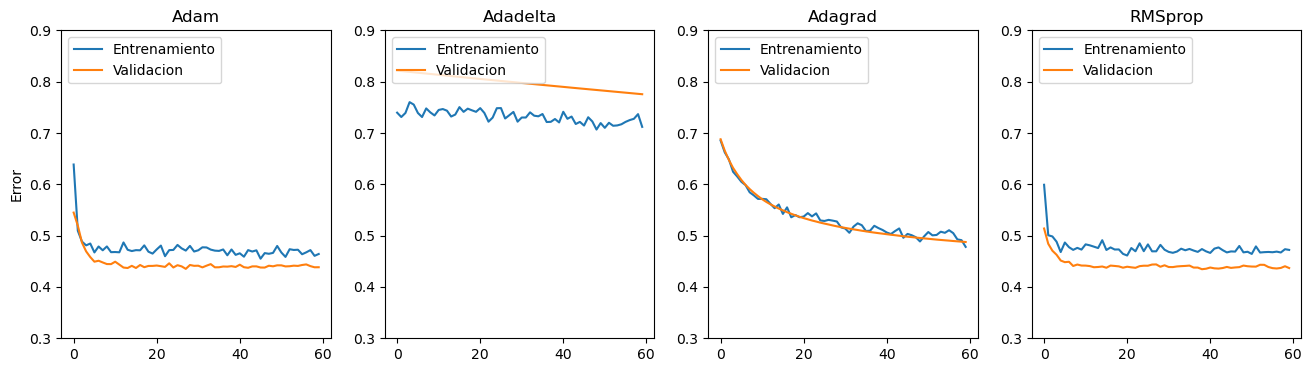

In [116]:
fig, ax = plt.subplots(1, 4, figsize=(16,4),)
title = ["Adam", "Adadelta", "Adagrad", "RMSprop"]

for i in range(4):
    ax[i].set_ylim(0.3,0.9)
    ax[i].plot(range(60), historyloss[i].history['loss'])
    ax[i].plot(range(60), historyloss[i].history['val_loss'])
    ax[i].legend(['Entrenamiento', 'Validacion'], loc='upper left')
    ax[i].set_title(title[i])

ax[0].set_ylabel('Error')
plt.show()

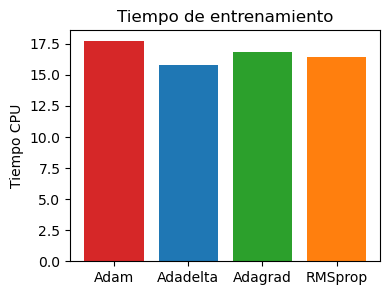

In [117]:
fig, ax = plt.subplots(1, 1, figsize=(4,3),)

Column = ["Adam", "Adadelta", "Adagrad", "RMSprop"]

bar_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange']

ax.bar(Column, time, color=bar_colors)

ax.set_ylabel('Tiempo CPU')
ax.set_title('Tiempo de entrenamiento')

plt.show()

## 1.m Testing 

Finalmente, luego de entrenar todos estos modelos estamos en condiciones de probar que tan bien fue nuestro desempeño. Para esto utilice el modelo en el cual obtuvo el mejor desempeño en validación y calcule el error de la predicción realizada sobre el _Test set_. Puede utilizar el metodo `.predict` de su modelo. 

¿Qué tan bien se desempeñaría su modelo en un caso real en vista de lo anterior? 

In [118]:
X_test[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = X_test[['Glucose',
'BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)
X_test = X_test.fillna(X_test.mean())

In [119]:
modelo_final=Drop(256,learning_r,'tanh')
results = modelo_final.evaluate(X_test, y_test)
print("test loss, test acc:", results)

3/3 [==============================] - 0s 4ms/step - loss: 0.9352
test loss, test acc: 0.935185432434082
